<a href="https://colab.research.google.com/github/burrittresearch/stock-market-forecasting-in-python/blob/main/stock-market-forecasting-in-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Forecasting in Python
This notebook includes coding and notes for future price of financial market assets including stocks, ETFs, and indices. A single class object was created to provide informational, cleaning, modeling, and visualization functions for processing financial asset data and predicting prices. Then all the available methods were run. Source data is downloaded from yfinance and then processed.

# Project Workflow
* Define the Problem
* Process Data
* Class Object AssetData Cleans, Models, and Visualizes Financial Data
* Run all Class Methods

# Define the Problem
Predict the future price of financial market assets including stocks, ETFs, and indices.

# Process Data

In [1]:
# Import libraries
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, 
  classification_report, 
  confusion_matrix, 
  f1_score, 
  mean_squared_error, precision_score,
  r2_score
) 
from sklearn.model_selection import train_test_split

# Install and import yfinance
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Set display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 3)



# Line break utility
str_lb = '\n \n'

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Class Object *AssetData* Cleans, Models, and Visualizes Financial Data

In [4]:
class AssetData:

  """
  Provides various informational, cleaning, modeling, and visualization functions for processing financial asset data
  and predicting prices. Source data is downloaded from yfinance and then processed.

  Parameters
  ----------
  str_co_ticker : str, required
    Any valid asset symbol.

  str_period : str, required, default 'max'
    Time duration for data.
    Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

  str_interval : str, required, default '1d'
    Time interval for data.
    Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

  update : bool, required, default False
    If True will download latest data and update csv file.
    If False will not download latest file data and will not update csv file.

  tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
     Tuple of valid intervals to run model.

  Methods
  ----------
  get_ticker
    Returns the asset ticker.
  
  get_period
    Returns the data time duration.
  
  get_interval
    Returns the data time interval.

  download_csv
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. If file already exists and update argumet is False, then existing file is not updated. If File 
    already exists and update argumet is True, then existing file is updated. If file doesn't exist, it is downloaded.
    Prints message indicating operations that were performed.

  get_raw_dataframes
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes.
    Returns the raw dataframe.

  explore_raw_dataframes
    Runs get_raw_dataframe and then prints basic dataframe information.

  get_clean_dataframes
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms. 

  get_visual_data
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms, and regplots.
  
  run_class_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints out various evaluation reports (bool_get_reports) and dataframes (bool_get_dfs)
    for each modeled interval. Then summarizes results of all model runs and prints out dataframe and visualization.

  run_class_model_list
    Runs run_class_model for a tuple of asset tickers.

  run_class_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints out various evaluation reports (bool_get_reports) and dataframes (bool_get_dfs)
    for each modeled interval. Then summarizes results of all model runs and prints out dataframe and visualization.

  run_class_model_list
    Runs run_class_model for a tuple of asset tickers.

  run_mlr_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for 
    intervals passed by tpl_model_intervals. By default, prints out various evaluation reports (bool_get_reports) and dataframes (bool_get_dfs)
    for each modeled interval. Then summarizes results of all model runs and prints out dataframe and visualization.

  run_mlr_model_list
    Runs run_mlr_model for a tuple of asset tickers.

  """

  def __init__(self, str_co_ticker, str_period='max', str_interval='1d', update=False, tpl_model_intervals=('1d', '1wk', '1mo')):

    """
    Initializes the class

    Parameters
    ----------
    str_co_ticker : str, required
    Any valid asset symbol.

    str_period : str, required, default 'max'
      Time duration for data.
      Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

    str_interval : str, required, default '1d'
      Time interval for data.
      Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

    update : bool, required, default False
      If True will download latest data and update csv file.
      If False will not download latest file data and will not update csv file.

    tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
      Tuple of valid intervals to run model.

    NOTE: Data is downloaded to csv from yfinance given above paramters.
          Data is stored is default drive location indicated below.
    
    """      
    
    self.str_co_ticker = str_co_ticker
    self.str_period = str_period
    self.str_interval = str_interval
    self.str_drive_loc = '/content/drive/MyDrive/Colab Notebooks/input/'
    self.update = update
    self.tpl_model_intervals = list(tpl_model_intervals)
    self.lst_features_plots = ['open', 
      'high', 
      'low', 
      'close', 
      'volume', 
      'target_price', 
      'target_class'
    ]

    self.lst_features_model = ['open', 
      'high', 
      'low', 
      'close', 
      'volume', 
      # 'target_price', 
      # 'target_class'
    ]

    self.global_font = 10
    self.local_font = 12

  def get_ticker(self):
    
    """
    Gets the asset ticker.

    Returns
    ----------
    Ticker symbol.
    
    """

    return self.str_co_ticker

  def get_period(self):

    """
    Gets the data time period duration.

    Returns
    ----------
    Time period duration.
    
    """

    return self.str_period

  def get_interval(self):

    """
    Gets the data time interval.

    Returns
    ----------
    Time interval.
    
    """

    return self.str_interval

  def download_csv(self):

    """
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. If file already exists and update argumet is False, then existing file is not updated. If File 
    already exists and update argumet is True, then existing file is updated. If file doesn't exist, it is downloaded.
    Prints message indicating operations that were performed.

    """

    update = self.update
    
    str_save_to_input = self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' + self.str_interval + '.csv'
    
    if Path(str_save_to_input).exists() is True and update is True:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)

    elif Path(str_save_to_input).exists() is True and update is False:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: NO{str_lb}')

    elif Path(str_save_to_input).exists() is False:
      print(f'FILE DOES NOT EXIST: {str(Path(str_save_to_input))} DOWNLOADED: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)
    
    return
  
  def get_raw_dataframes(self):

    """
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes.
    Returns the raw dataframe.
    
    Returns
    ----------
    Raw dataframe.

    """
 
    self.download_csv()
    str_save_to_input = self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' + self.str_interval + '.csv'
    df = pd.read_csv(str_save_to_input, index_col=['Date'], parse_dates=['Date'])
    
    return df

  def explore_raw_dataframes(self):

    """
    Runs get_raw_dataframe and then prints basic dataframe information.

    """

    df = self.get_raw_dataframes()
    
    # Explore data
    df.info()

    print(f'df.head(): {str_lb}{df.head()}{str_lb}',    
      f'df.shape: {str_lb}{df.shape}{str_lb}',
      f'df.describe(): {str_lb}{df.describe()}{str_lb}',
      f'df.corr(method="pearson"): {str_lb}{df.corr(method="pearson")}{str_lb}'
    )

    return

  def get_clean_dataframes(self):

    """
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms. 

    """

    df = self.get_raw_dataframes()

    # Drop and rename columns, rename index
    df.drop(['Adj Close'], axis=1, inplace=True)
    dict_rename = ({'Open':'open',
      'High':'high', 
      'Low':'low', 
      'Close':'close', 
      'Volume':'volume', 
    })
    df.rename(columns=dict_rename, inplace=True)
    df.index.rename('date', inplace=True)

    # Create target price and target class price from next period's close
    df['target_price'] = df['close'].shift(-1)
    df['target_class'] = np.where(df.target_price > df.close, 2, 1)

    # Slice the dataframe up one period to avoid target price null calculation 
    df = df.iloc[:-1]

    # Copy dataframe
    df = df.copy()
    
    return df
   
  def get_visual_data(self):

    """
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms, and regplots.

    """

    # Set plot options
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")

    # Assign global font size
    plt.rcParams['font.size'] = self.global_font

    # Get clean dataframe for visualizations
    df = self.get_clean_dataframes()

    # Create line plot and correlation heatmap
    fig = plt.figure(figsize=(13.6, 4))
    fig.subplots_adjust(wspace=0.50, hspace=0.50) 

    # Line plot
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(df.close, label='Close')
    ax.set_title(f'Price', fontsize=self.local_font)
    ax.legend(loc='upper left')
    
    # Correlation heatmap
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f'Feature Correlation Heatmap', fontsize=self.local_font)
    sns.heatmap(df.corr(method = 'pearson'), cmap='Oranges', center=1, annot=True, fmt='.2f', linewidth=0.5)
    
    fig.suptitle(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}', y=1.10, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Assign number of records to visualize pairplot
    int_rows = 10

    # Create pairplot of features list
    sns.set(font_scale=0.75)
    ax = sns.pairplot(df[-int_rows:], hue='target_price', vars=self.lst_features_plots, diag_kind='kde')
    ax.fig.set_size_inches(11.9, 7)
    ax.fig.suptitle(f'Feature and Target Pairplots (Records: {int_rows})', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Create histograms of features list
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))
      
    for int_index, str_feature in enumerate(self.lst_features_plots):
      
      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      ax.hist(df[str_feature], bins=50, color='green', edgecolor='black')
      ax.set_title(str_feature, fontsize=self.local_font)
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Histograms', y=1.10, fontsize=self.local_font)
    
    plt.show()
    print(str_lb)

    # Create regplots of features and target
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))
      
    for int_index, str_feature in enumerate(self.lst_features_plots):
      
      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      sns.regplot(x=df[str_feature], y=df['target_price'], color='blue', line_kws={'color': 'red', 'lw': 3})
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Regplots', y=1.10, fontsize=self.local_font)
    
    plt.show()
    
    return


  def run_class_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints out various evaluation reports (bool_get_reports) and dataframes (bool_get_dfs)
    for each modeled interval. Then summarizes results of all model runs and prints out dataframe and visualization.

    Parameters
    ----------
    bool_get_reports : bool, default True
      If True will print various evaluation reports.
    
    bool_get_dfs : bool, default True
      If True, will print evaluation dataframes.
    ----------
    
    """
    
    # Create lists for scores
    lst_int = []
    lst_flt_accuracy_score = []
    lst_f1_score = []
    lst_flt_precision_score = []
    lst_flt_score = []

    # Create list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loop through intervals and run model
    for interval in self.tpl_model_intervals:
            
      # Assign an interval to class attribute
      self.str_interval = interval

      # Check for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_class_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Print model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Get clean dataframe for model 
      df = self.get_clean_dataframes()

      # Create the training and test sets
      X = df[self.lst_features_model]
      y = df.target_class

      # Manually split sets by date to avoid leakage and then randomize
      flt_train_pct = 0.75
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Create the model using random forest classification
      rf_model_price_data = RandomForestClassifier()

      # Train the model
      rf_model_price_data.fit(X_train, y_train)

      # Predict asset values for test set
      y_hat = rf_model_price_data.predict(X_test)

      # Create new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_class'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluate the results
      flt_accuracy_score = accuracy_score(y_test, y_hat)
      flt_f1_score = f1_score(y_test, y_hat, average='macro')
      flt_precision_score = precision_score(y_test, y_hat)
      flt_score = rf_model_price_data.score(X_test, y_test)

      # Create lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_accuracy_score.append(flt_accuracy_score)
      lst_f1_score.append(flt_f1_score)
      lst_flt_precision_score.append(flt_precision_score)
      lst_flt_score.append(flt_score)

      # Create dictionary to store evaluation results
      dict_scores = {'lst_flt_accuracy_score':lst_flt_accuracy_score,
        'lst_f1_score':lst_f1_score,
        'lst_flt_precision_score':lst_flt_precision_score,
        'lst_flt_score':lst_flt_score
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Classification Report:{str_lb}{classification_report(y_test, y_hat)}{str_lb}')
        print(f"Crosstab Confusion Matrix:{str_lb}{pd.crosstab(df_pred.target_class, df_pred.target_pred, rownames=['Actual Classification'], colnames=['Predicted Classification'])}{str_lb}")
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        arr_conf_matrix = confusion_matrix(df_pred.target_class, df_pred.target_pred)
        sns.heatmap(arr_conf_matrix, cmap='Greens', center=1, annot=True, fmt='.1f', linewidth=0.5, xticklabels=['1', '2'], yticklabels=['1', '2'])
        ax.set_xlabel('Actual Classification')
        ax.set_ylabel('Predicted Classification')
        ax.set_title(f'Predicted vs Actual Asset Values Classification Model Confusion Matrix{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: {str_lb}{df_pred.tail(10)}{str_lb}')

    # Print a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualize summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 4))
    ax = fig.add_subplot()
    df_score_comp_class.plot(kind='bar', ax=ax)
    ax.set_title(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', fontsize=self.local_font)
    ax.legend(loc='upper left')
    plt.show()
    print(str_lb)

    return 

  def run_class_model_list(self, tpl_assets):

    """
    Runs run_class_model for a tuple of asset tickers.

    """  

    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)
                  
    for asset in lst_assets:
       self.str_co_ticker = asset
       print(self.run_class_model())
    
    return

  def run_mlr_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for 
    intervals passed by tpl_model_intervals. By default, prints out various evaluation reports (bool_get_reports) and dataframes (bool_get_dfs)
    for each modeled interval. Then summarizes results of all model runs and prints out dataframe and visualization.

    """
    
    # Create lists for scores
    lst_int = []
    lst_flt_score = []
    lst_flt_r2_score = []
    lst_flt_mse = []

    # Create list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loop through intervals and run model
    for interval in self.tpl_model_intervals:
            
      # Assign an interval to class attribute
      self.str_interval = interval

      # Check for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_mlr_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Print model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Get clean dataframe for model 
      df = self.get_clean_dataframes()

      # Create the training and test sets
      X = df[self.lst_features_model]
      y = df.target_price

      # Manually split sets by date to avoid leakage and then randomize
      flt_train_pct = 0.75
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Create the model using multiple linear regression
      mlr_model_price_data = LinearRegression()

      # Train the model
      mlr_model_price_data.fit(X_train, y_train)

      # Predict asset values for test set
      y_hat = mlr_model_price_data.predict(X_test)

      # Create new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_price'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluate the results
      flt_score = mlr_model_price_data.score(X_test, y_test)
      flt_r2_score = r2_score(y_test, y_hat)
      flt_mse = mean_squared_error(y_test, y_hat)

      # Create lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_score.append(flt_score)
      lst_flt_r2_score.append(flt_r2_score)
      lst_flt_mse.append(flt_mse)

      # Create dictionary to store evaluation results
      dict_scores = {'lst_flt_score':lst_flt_score,
        'lst_flt_r2_score':lst_flt_r2_score,
        'lst_flt_mse':lst_flt_mse,
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Model Coefficents: {str_lb}{mlr_model_price_data.coef_}{str_lb}')
        print(f'Model Intercept: {str_lb}{mlr_model_price_data.intercept_}{str_lb}')

        # Plot the results
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        x = df_pred.index
        y = df_pred.target_price
        y_hat = df_pred.target_pred
        ax.plot(x, y, color='g', label='target_price', linestyle='-', linewidth=2)
        ax.plot(x, y_hat, color='b', label='target_pred', linestyle=':', linewidth=5)
        ax.set_title(f'Predicted vs Actual Asset Values Using Multiple Regression{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        ax.legend(loc='upper left')
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: {str_lb}{df_pred.tail(10)}{str_lb}')

    # Print a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualize summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 4))
    ax = fig.add_subplot()
    df_score_comp_class.plot(kind='bar', ax=ax)
    ax.set_title(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', fontsize=self.local_font)
    ax.legend(loc='upper left')
    plt.show()
    print(str_lb)
    
    return 

  def run_mlr_model_list(self, tpl_assets):

    """
    Runs run_mlr_model for a tuple of asset tickers.

    """

    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)
                
    for asset in lst_assets:
      self.str_co_ticker = asset
      print(self.run_mlr_model())

    return



# Method get_ticker

In [5]:
AssetData('ibm').get_ticker()

'ibm'

# Method get_period

In [6]:
AssetData('ibm').get_period()

'max'

# Method get_interval

In [7]:
AssetData('ibm').get_interval()

'1d'

# Method download_csv

In [8]:
AssetData('ibm').download_csv()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 



# Method get_raw_dataframes

In [9]:
AssetData('ibm').get_raw_dataframes()


FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.374,7.374,7.291,7.291,1.613,407940
1962-01-03,7.291,7.355,7.291,7.355,1.627,305955
1962-01-04,7.355,7.355,7.279,7.282,1.611,274575
1962-01-05,7.272,7.272,7.126,7.138,1.579,384405
1962-01-08,7.132,7.132,6.947,7.004,1.550,572685
...,...,...,...,...,...,...
2023-04-17,128.300,128.720,126.800,127.820,127.820,3662700
2023-04-18,128.140,128.680,127.350,127.780,127.780,3193800
2023-04-19,126.500,126.980,125.300,126.320,126.320,7014400


# Method explore_raw_dataframes

In [10]:
AssetData('ibm').explore_raw_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15432 entries, 1962-01-02 to 2023-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       15432 non-null  float64
 1   High       15432 non-null  float64
 2   Low        15432 non-null  float64
 3   Close      15432 non-null  float64
 4   Adj Close  15432 non-null  float64
 5   Volume     15432 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 843.9 KB
df.head(): 
 
            Open   High   Low    Close  Adj Close  Volume
Date                                                     
1962-01-02  7.374  7.374  7.291  7.291  1.613      407940
1962-01-03  7.291  7.355  7.291  7.355  1.627      305955
1962-01-04  7.355  7.355  7.279  7.282  1.611      274575
1962-01-05  7.272  7.272  7.126  7.138  1.579      384405
1962-01-08  7.132  7.132  6.947  7.004  1.5

# Method get_clean_dataframes

In [11]:
AssetData('ibm').get_clean_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 



,open,high,low,close,volume,target_price,target_class
date,,,,,,,
1962-01-02,7.374,7.374,7.291,7.291,407940,7.355,2
1962-01-03,7.291,7.355,7.291,7.355,305955,7.282,1
1962-01-04,7.355,7.355,7.279,7.282,274575,7.138,1
1962-01-05,7.272,7.272,7.126,7.138,384405,7.004,1
1962-01-08,7.132,7.132,6.947,7.004,572685,7.087,2
...,...,...,...,...,...,...,...
2023-04-14,128.460,129.840,127.310,128.140,4180100,127.820,1
2023-04-17,128.300,128.720,126.800,127.820,3662700,127.780,1
2023-04-18,128.140,128.680,127.350,127.780,3193800,126.320,1


# Method get_visual_data

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 



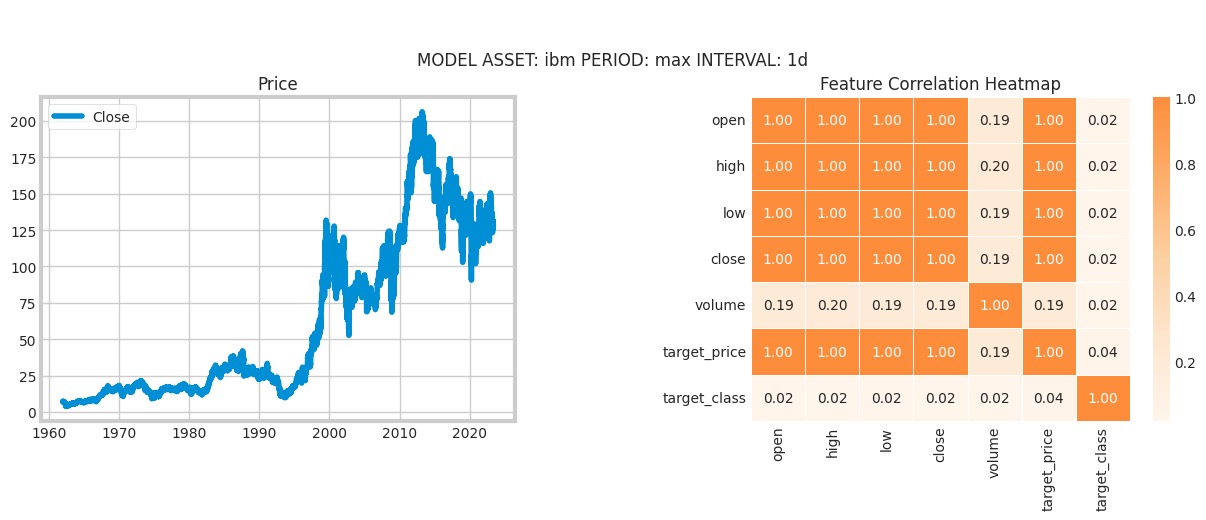

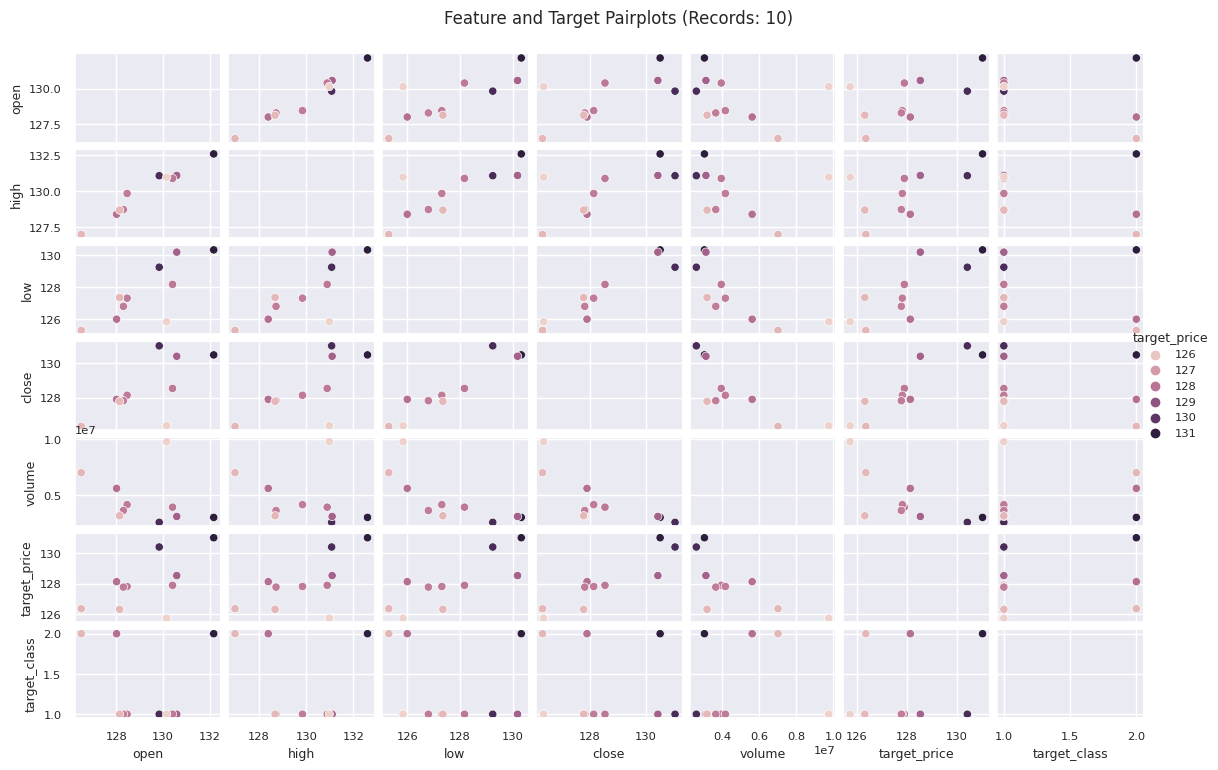

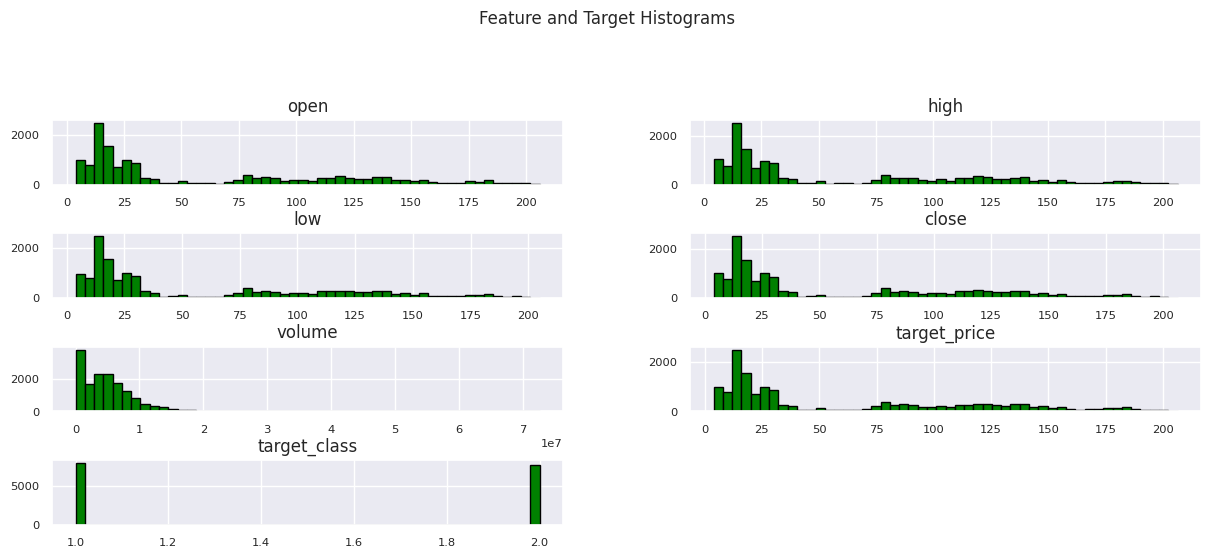

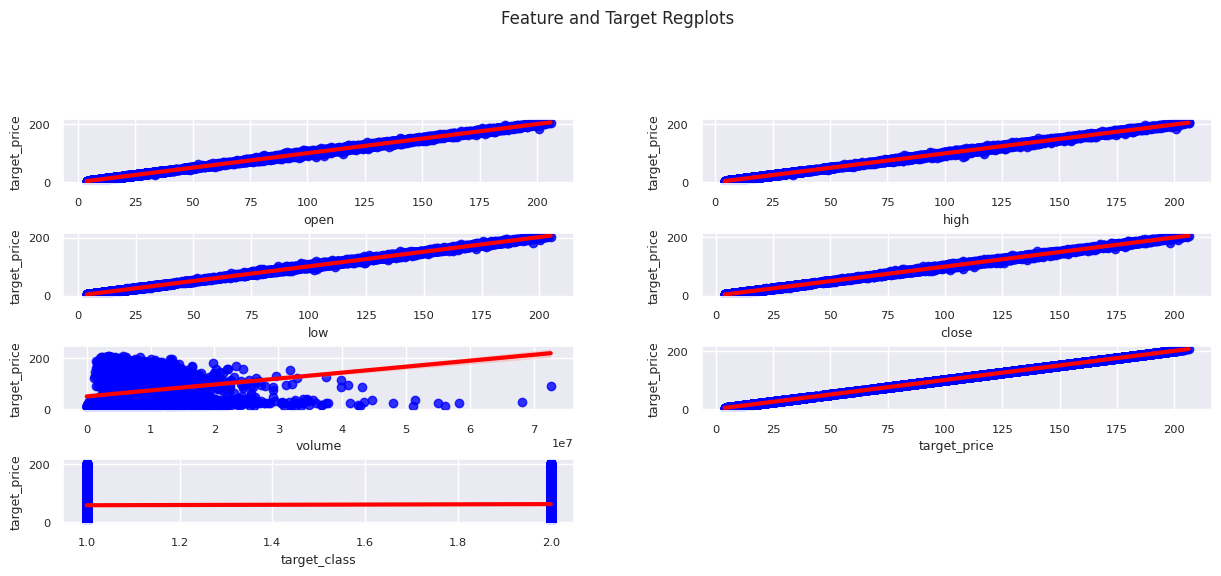

In [12]:
AssetData('ibm').get_visual_data()

# Method run_class_model


 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.49      0.87      0.63      1889
           2       0.52      0.14      0.22      1969

    accuracy                           0.50      3858
   macro avg       0.51      0.50      0.42      3858
weighted avg       0.51      0.50      0.42      3858

 

Crosstab Confusion Matrix:
 
Predicted Classification  1     2  
Actual Classification              
1                         1637  252
2                         1694  275
 



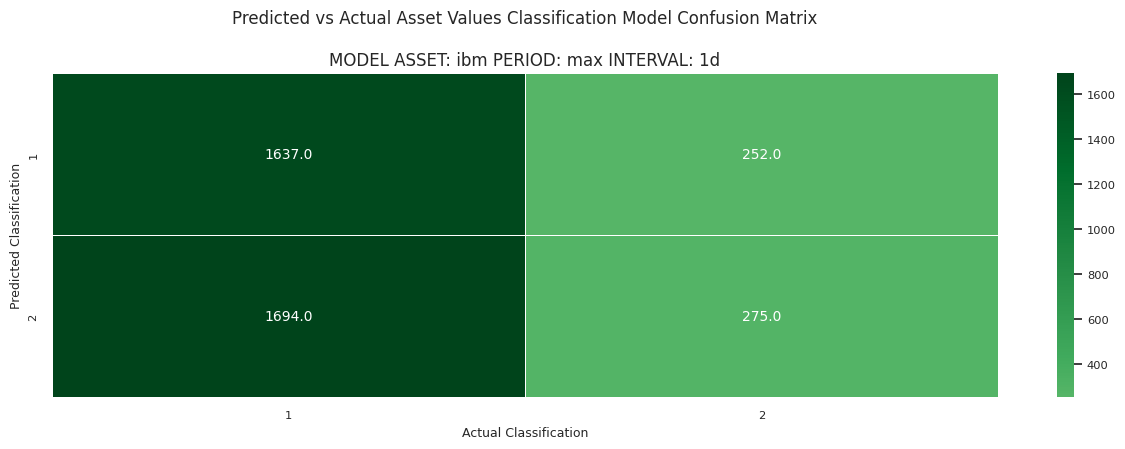


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_class  target_pred
date                                                                          
2023-04-06  132.16  132.60  130.32  130.50  3050600  2             1          
2023-04-10  129.83  131.08  129.24  131.03  2614400  1             1          
2023-04-11  130.58  131.10  130.18  130.42  3132400  1             1          
2023-04-12  130.40  130.89  128.17  128.54  3957500  1             1          
2023-04-13  128.01  128.39  126.00  127.90  5621500  2             1          
2023-04-14  128.46  129.84  127.31  128.14  4180100  1             2          
2023-04-17  128.30  128.72  126.80  127.82  3662700  1             1          
2023-04-18  128.14  128.68  127.35  127.78  3193800  1             1          
2023-04-19  126.50  126.98  125.30  126.32  7014400  2             2          
2023-04-20  130.15  130.98  125.84  126.36  9749600  1             2          
 


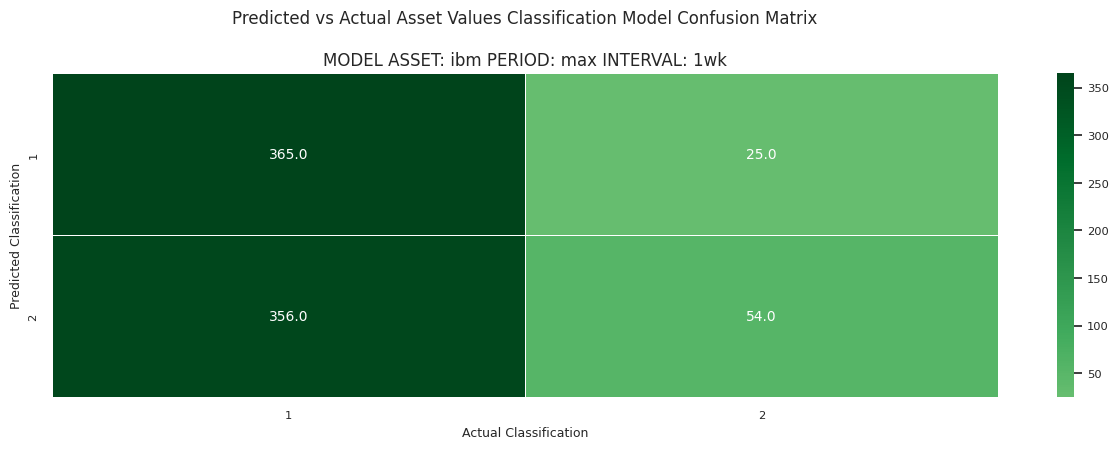


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_class  target_pred
date                                                                           
2023-02-06  135.83  136.74  133.34  135.60  22141000  1             1          
2023-02-13  136.00  137.39  133.89  135.02  16543600  1             1          
2023-02-20  134.00  134.39  128.86  130.57  14198800  1             1          
2023-02-27  131.42  131.87  127.71  129.64  17865500  1             1          
2023-03-06  129.64  130.86  125.13  125.45  20909600  1             1          
2023-03-13  125.15  128.19  121.71  123.69  66131400  2             1          
2023-03-20  124.31  127.22  122.60  125.29  20457800  2             1          
2023-03-27  126.47  131.48  126.47  131.09  20778500  1             1          
2023-04-03  130.97  132.61  130.32  130.50  13172200  1             1          
2023-04-10  129.83  131.10  126.00  128.14  19505900  1             1 

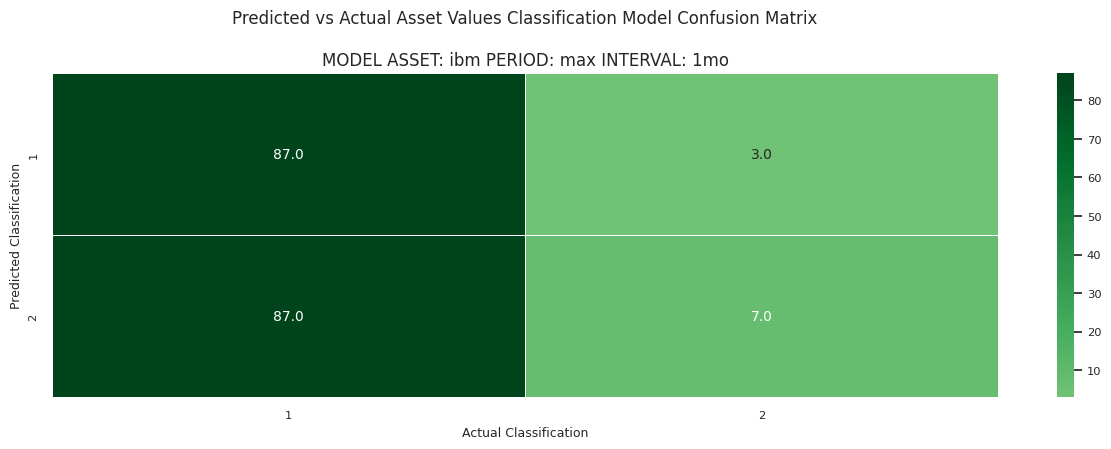


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_class  target_pred
date                                                                            
2022-06-01  139.67  144.73  132.85  141.19  105811300  1             1          
2022-07-01  141.00  141.87  125.13  130.79  129791800  1             1          
2022-08-01  130.75  139.34  128.40  128.45   77419800  1             1          
2022-09-01  128.40  130.99  118.61  118.81   87265100  2             1          
2022-10-01  120.16  138.86  115.55  138.29  113478200  2             1          
2022-11-01  138.25  150.46  133.97  148.90   93661300  1             1          
2022-12-01  149.98  153.21  137.20  140.89   86424100  1             1          
2023-01-01  141.10  147.18  132.98  134.73  105575000  1             1          
2023-02-01  134.49  137.39  128.86  129.30   76080200  2             1          
2023-03-01  128.90  131.48  121.71  131.09  138238400  1   

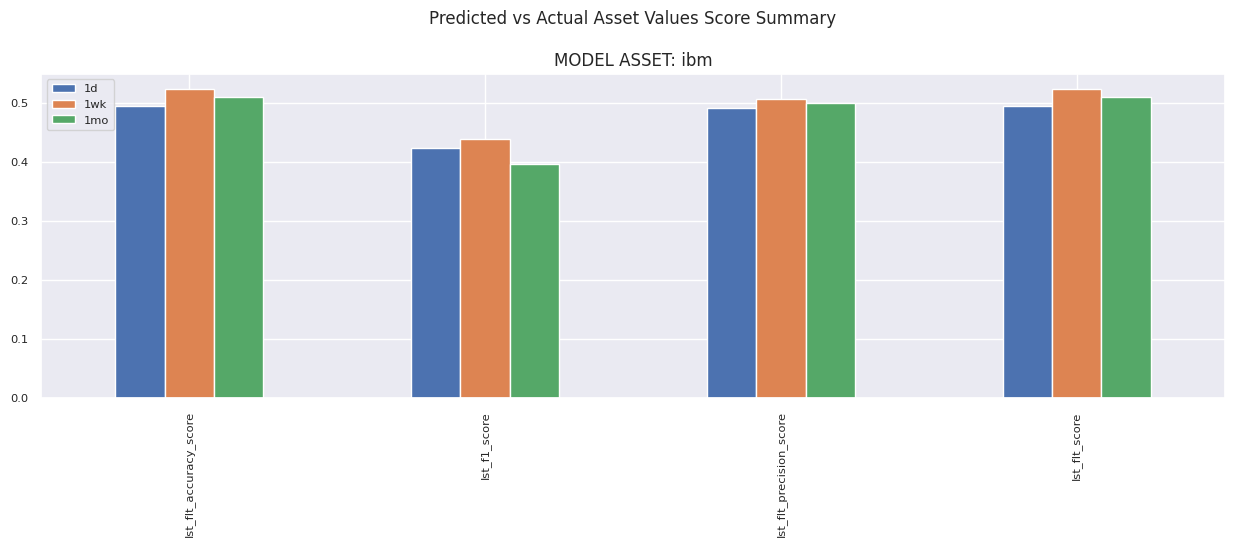

In [13]:
AssetData('ibm').run_class_model()

# Method run_class_model_list


 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.49      0.87      0.63      1889
           2       0.53      0.14      0.22      1969

    accuracy                           0.50      3858
   macro avg       0.51      0.51      0.42      3858
weighted avg       0.51      0.50      0.42      3858

 

Crosstab Confusion Matrix:
 
Predicted Classification  1     2  
Actual Classification              
1                         1652  237
2                         1702  267
 



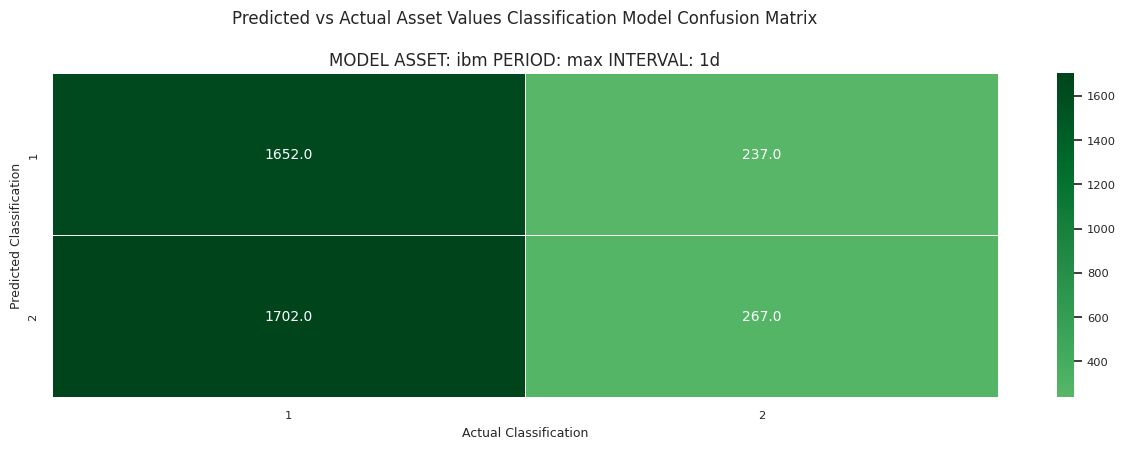


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_class  target_pred
date                                                                          
2023-04-06  132.16  132.60  130.32  130.50  3050600  2             1          
2023-04-10  129.83  131.08  129.24  131.03  2614400  1             1          
2023-04-11  130.58  131.10  130.18  130.42  3132400  1             1          
2023-04-12  130.40  130.89  128.17  128.54  3957500  1             1          
2023-04-13  128.01  128.39  126.00  127.90  5621500  2             1          
2023-04-14  128.46  129.84  127.31  128.14  4180100  1             1          
2023-04-17  128.30  128.72  126.80  127.82  3662700  1             1          
2023-04-18  128.14  128.68  127.35  127.78  3193800  1             1          
2023-04-19  126.50  126.98  125.30  126.32  7014400  2             2          
2023-04-20  130.15  130.98  125.84  126.36  9749600  1             2          
 


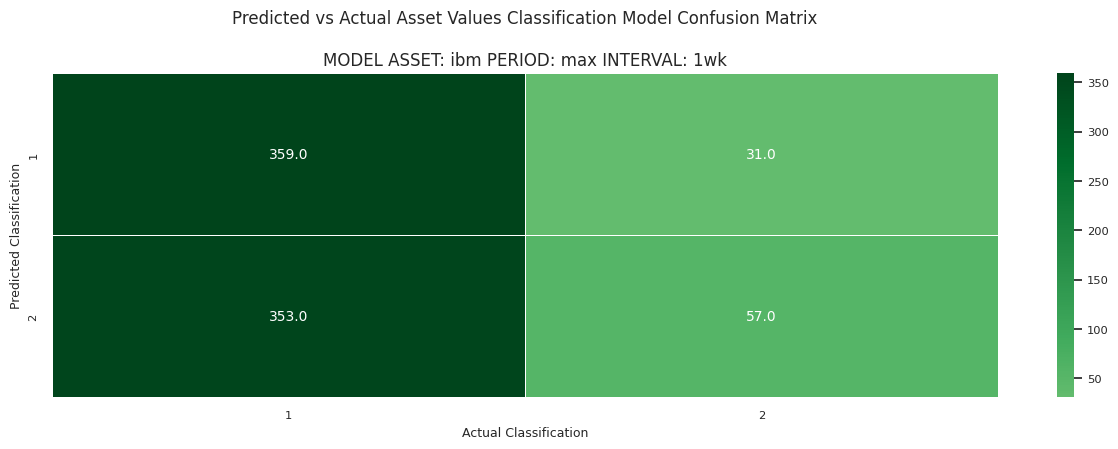


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_class  target_pred
date                                                                           
2023-02-06  135.83  136.74  133.34  135.60  22141000  1             1          
2023-02-13  136.00  137.39  133.89  135.02  16543600  1             1          
2023-02-20  134.00  134.39  128.86  130.57  14198800  1             1          
2023-02-27  131.42  131.87  127.71  129.64  17865500  1             1          
2023-03-06  129.64  130.86  125.13  125.45  20909600  1             1          
2023-03-13  125.15  128.19  121.71  123.69  66131400  2             1          
2023-03-20  124.31  127.22  122.60  125.29  20457800  2             1          
2023-03-27  126.47  131.48  126.47  131.09  20778500  1             1          
2023-04-03  130.97  132.61  130.32  130.50  13172200  1             1          
2023-04-10  129.83  131.10  126.00  128.14  19505900  1             1 

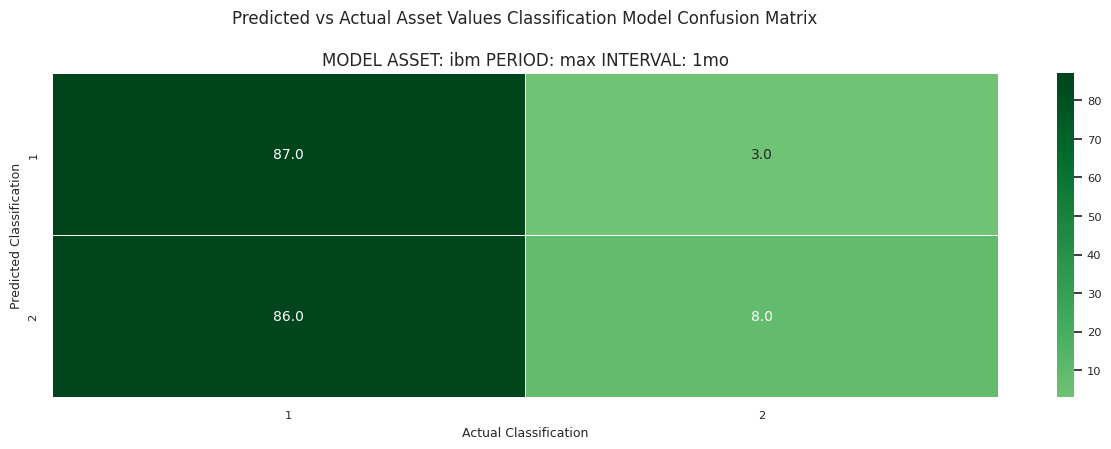


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_class  target_pred
date                                                                            
2022-06-01  139.67  144.73  132.85  141.19  105811300  1             1          
2022-07-01  141.00  141.87  125.13  130.79  129791800  1             1          
2022-08-01  130.75  139.34  128.40  128.45   77419800  1             1          
2022-09-01  128.40  130.99  118.61  118.81   87265100  2             1          
2022-10-01  120.16  138.86  115.55  138.29  113478200  2             1          
2022-11-01  138.25  150.46  133.97  148.90   93661300  1             1          
2022-12-01  149.98  153.21  137.20  140.89   86424100  1             1          
2023-01-01  141.10  147.18  132.98  134.73  105575000  1             1          
2023-02-01  134.49  137.39  128.86  129.30   76080200  2             1          
2023-03-01  128.90  131.48  121.71  131.09  138238400  1   

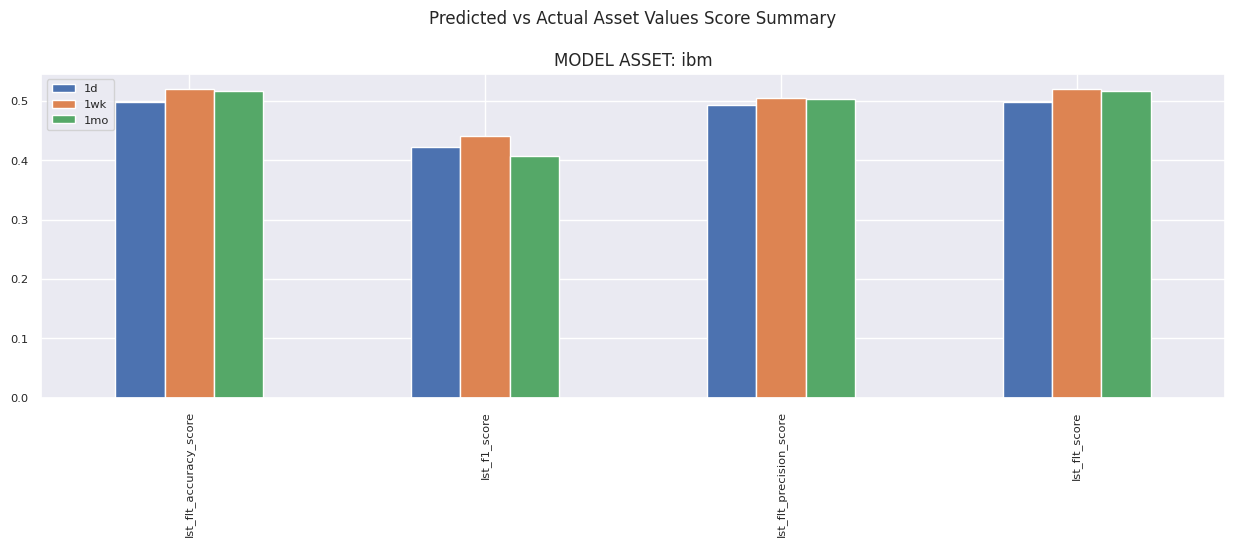


 

None

 
MODEL ASSET: ge PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ge-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.50      0.25      0.34      1964
           2       0.49      0.74      0.59      1895

    accuracy                           0.49      3859
   macro avg       0.50      0.50      0.46      3859
weighted avg       0.50      0.49      0.46      3859

 

Crosstab Confusion Matrix:
 
Predicted Classification  1    2   
Actual Classification              
1                         497  1467
2                         488  1407
 



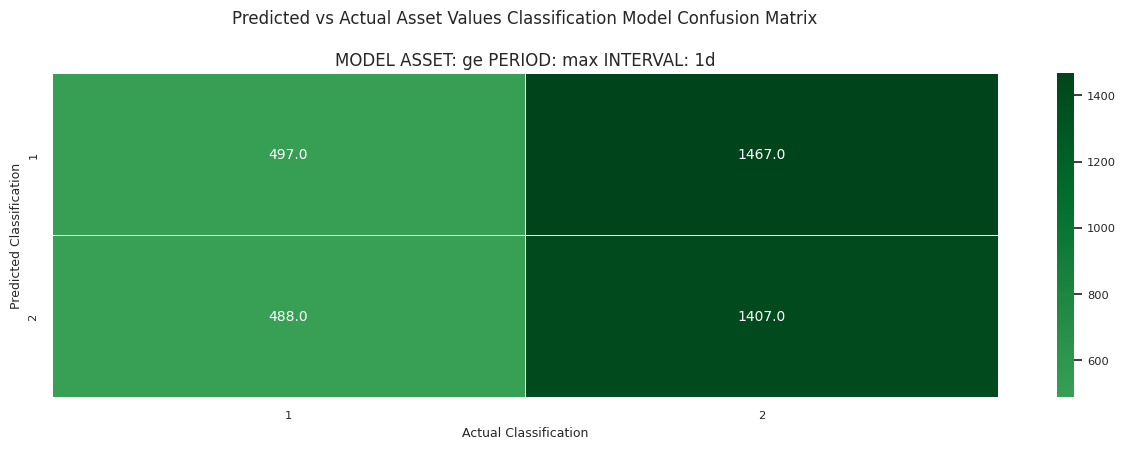


 

Feature, Target and Prediction Comparison: 
 
            open    high    low    close   volume   target_class  target_pred
date                                                                         
2023-04-14   93.86   95.64  93.81   95.44  5754600  2             2          
2023-04-17   95.62   96.85  95.48   96.77  6126100  2             1          
2023-04-18   97.00   98.52  96.86   98.47  7110800  2             1          
2023-04-19   98.58   99.31  98.42   99.03  5617000  2             1          
2023-04-20   99.30  100.47  99.06   99.76  6912400  1             1          
2023-04-21   99.98  100.08  99.13   99.51  4079400  2             1          
2023-04-24   99.58  100.77  99.58  100.15  6251800  1             1          
2023-04-25  101.95  102.01  97.55   98.44  9297500  1             2          
2023-04-26   98.23   98.45  96.09   96.21  6410500  2             1          
2023-04-27   97.02   98.19  96.60   98.06  7458800  2             1          
 


 
MODEL AS

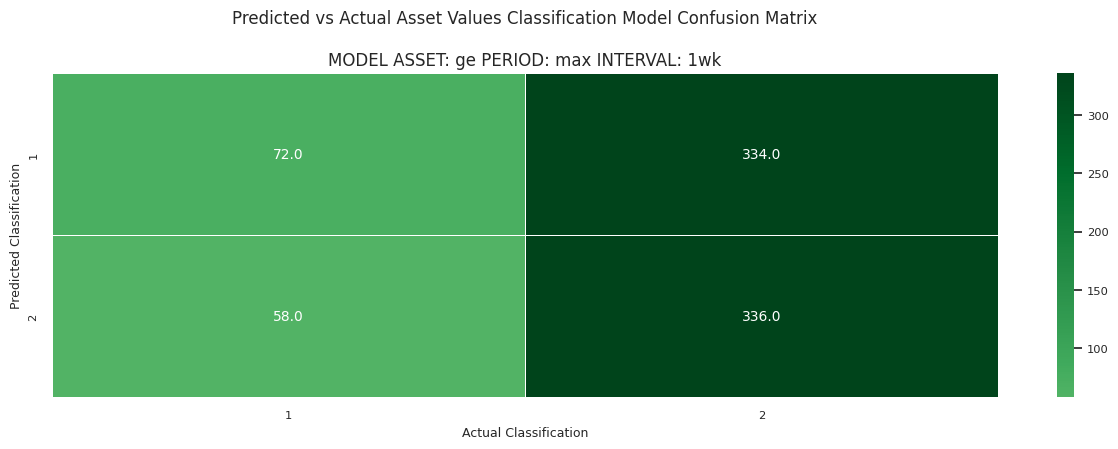


 

Feature, Target and Prediction Comparison: 
 
            open   high   low    close  volume    target_class  target_pred
date                                                                       
2023-02-06  81.47  82.63  80.40  81.29  19790900  2             1          
2023-02-13  81.20  84.79  81.08  83.04  24210700  2             2          
2023-02-20  82.14  84.41  81.65  83.55  27738300  2             1          
2023-02-27  84.00  87.04  83.38  86.38  36014800  2             2          
2023-03-06  86.64  94.94  86.07  91.00  66484000  1             2          
2023-03-13  89.70  93.08  86.45  90.29  53054500  2             2          
2023-03-20  90.63  93.04  89.41  91.37  36090800  2             2          
2023-03-27  92.28  95.67  92.11  95.60  27594000  1             2          
2023-04-03  95.75  97.87  93.54  93.60  26673600  2             2          
2023-04-10  93.83  95.64  93.47  95.44  32870100  2             2          
 


 
MODEL ASSET: ge PERIOD: max INTE

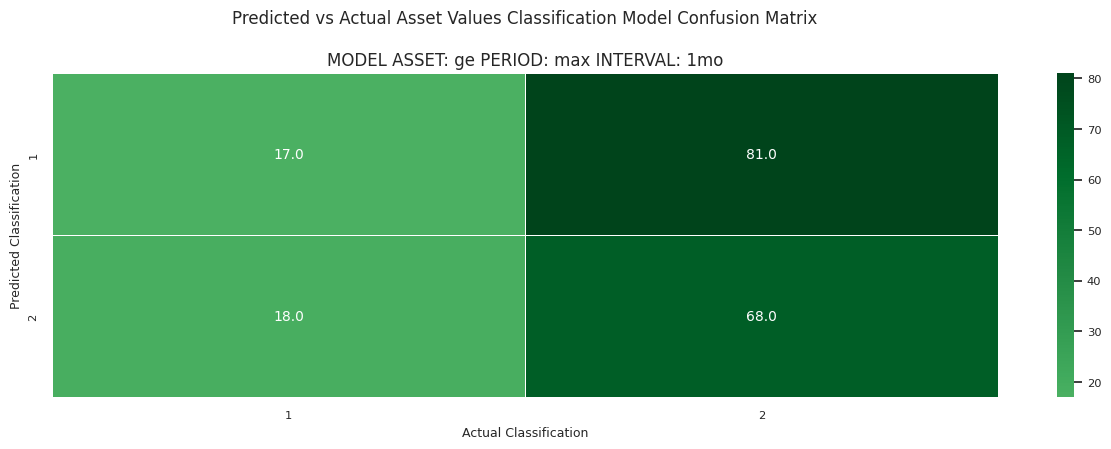


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_class  target_pred
date                                                                            
2022-06-01  61.733  62.014  48.212  49.703  190537220  2             1          
2022-07-01  49.563  58.470  46.784  57.697  180923701  1             1          
2022-08-01  57.221  63.466  56.745  57.330  162417348  1             1          
2022-09-01  57.182  59.711  48.306  48.329  179641805  2             2          
2022-10-01  48.993  61.561  48.517  60.742  163760479  2             1          
2022-11-01  61.327  68.993  59.774  67.112  148623415  1             1          
2022-12-01  67.299  67.994  59.867  65.410  154746594  2             2          
2023-01-01  65.613  83.990  65.215  80.480  192435233  2             2          
2023-02-01  80.270  85.650  80.010  84.710  108604900  2             2          
2023-03-01  84.660  95.670  83.380  95.600  203716600  2   

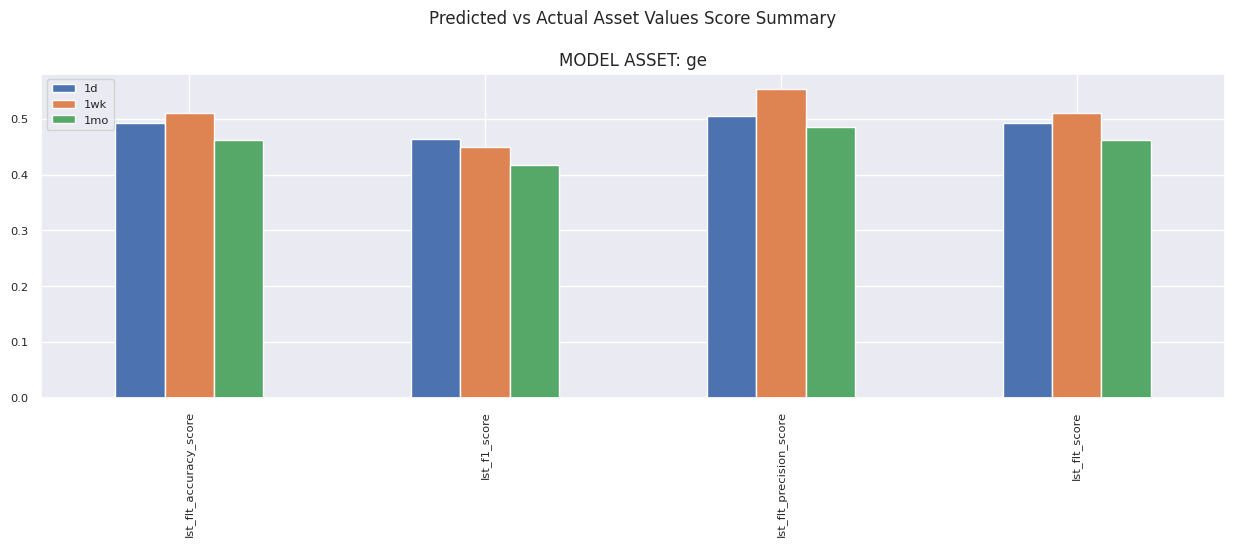


 

None

 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.49      0.86      0.62      1889
           2       0.51      0.14      0.22      1969

    accuracy                           0.49      3858
   macro avg       0.50      0.50      0.42      3858
weighted avg       0.50      0.49      0.42      3858

 

Crosstab Confusion Matrix:
 
Predicted Classification  1     2  
Actual Classification              
1                         1621  268
2                         1695  274
 



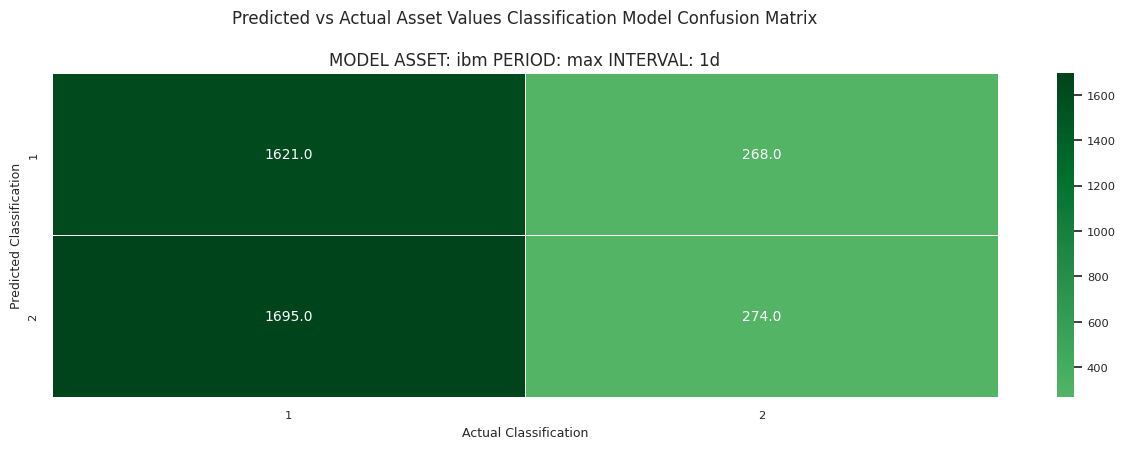


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_class  target_pred
date                                                                          
2023-04-06  132.16  132.60  130.32  130.50  3050600  2             1          
2023-04-10  129.83  131.08  129.24  131.03  2614400  1             1          
2023-04-11  130.58  131.10  130.18  130.42  3132400  1             1          
2023-04-12  130.40  130.89  128.17  128.54  3957500  1             1          
2023-04-13  128.01  128.39  126.00  127.90  5621500  2             1          
2023-04-14  128.46  129.84  127.31  128.14  4180100  1             2          
2023-04-17  128.30  128.72  126.80  127.82  3662700  1             1          
2023-04-18  128.14  128.68  127.35  127.78  3193800  1             1          
2023-04-19  126.50  126.98  125.30  126.32  7014400  2             2          
2023-04-20  130.15  130.98  125.84  126.36  9749600  1             2          
 


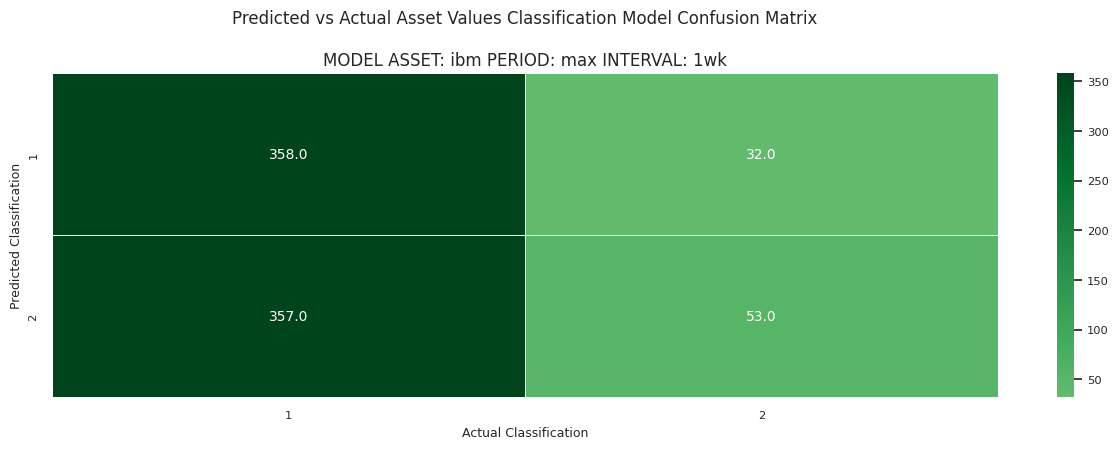


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_class  target_pred
date                                                                           
2023-02-06  135.83  136.74  133.34  135.60  22141000  1             1          
2023-02-13  136.00  137.39  133.89  135.02  16543600  1             1          
2023-02-20  134.00  134.39  128.86  130.57  14198800  1             1          
2023-02-27  131.42  131.87  127.71  129.64  17865500  1             1          
2023-03-06  129.64  130.86  125.13  125.45  20909600  1             1          
2023-03-13  125.15  128.19  121.71  123.69  66131400  2             1          
2023-03-20  124.31  127.22  122.60  125.29  20457800  2             1          
2023-03-27  126.47  131.48  126.47  131.09  20778500  1             1          
2023-04-03  130.97  132.61  130.32  130.50  13172200  1             1          
2023-04-10  129.83  131.10  126.00  128.14  19505900  1             1 

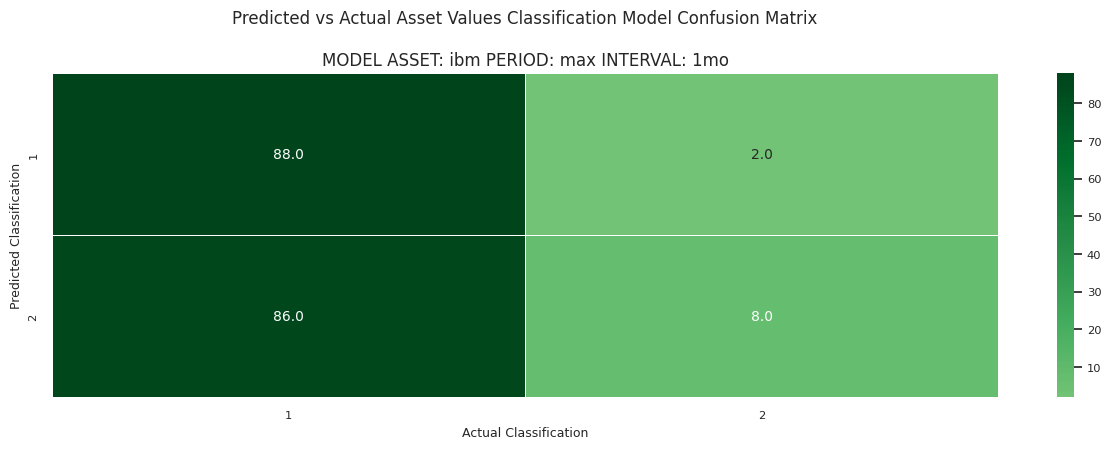


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_class  target_pred
date                                                                            
2022-06-01  139.67  144.73  132.85  141.19  105811300  1             1          
2022-07-01  141.00  141.87  125.13  130.79  129791800  1             1          
2022-08-01  130.75  139.34  128.40  128.45   77419800  1             1          
2022-09-01  128.40  130.99  118.61  118.81   87265100  2             1          
2022-10-01  120.16  138.86  115.55  138.29  113478200  2             1          
2022-11-01  138.25  150.46  133.97  148.90   93661300  1             1          
2022-12-01  149.98  153.21  137.20  140.89   86424100  1             1          
2023-01-01  141.10  147.18  132.98  134.73  105575000  1             1          
2023-02-01  134.49  137.39  128.86  129.30   76080200  2             1          
2023-03-01  128.90  131.48  121.71  131.09  138238400  1   

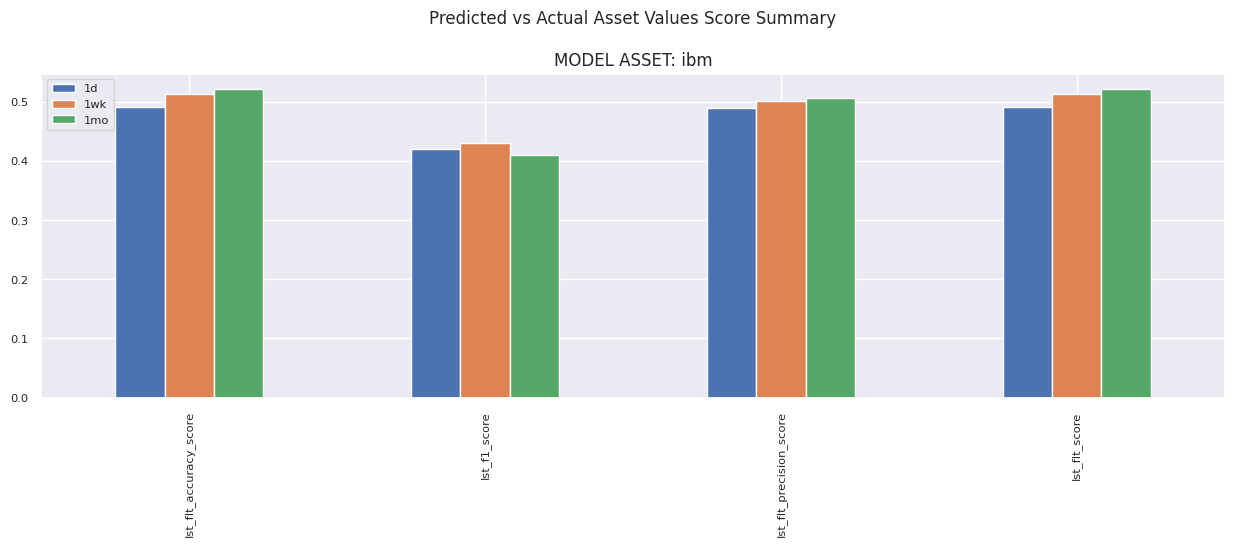


 

None


In [14]:
AssetData('ibm').run_class_model_list(['ibm', 'ge'])

# Method run_mlr_model


 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.50325970e-01  2.80622183e-01  1.60257955e-01  7.07482479e-01
  2.76780571e-09]
 

Model Intercept: 
 
0.01643718516954351
 



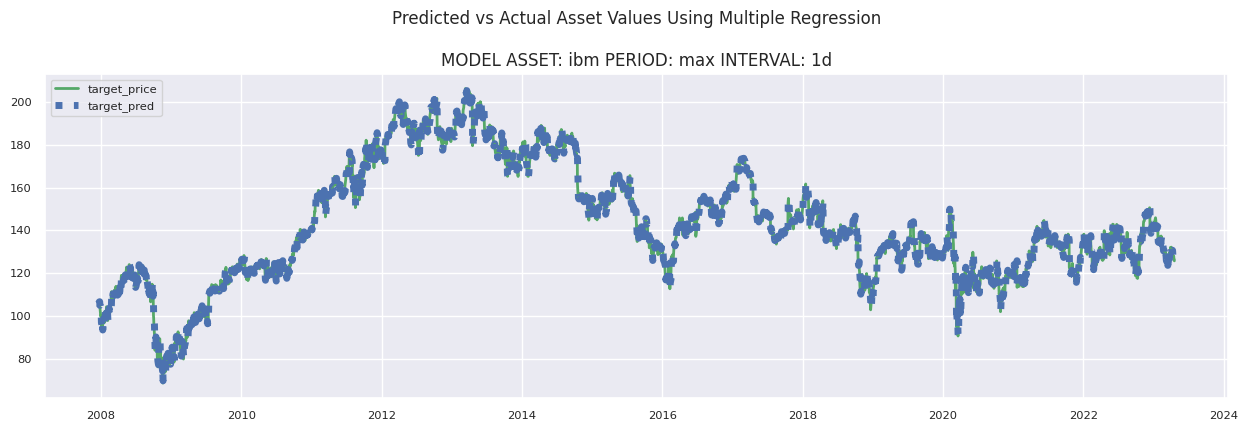


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_price  target_pred
date                                                                          
2023-04-06  132.16  132.60  130.32  130.50  3050600  131.03        130.580    
2023-04-10  129.83  131.08  129.24  131.03  2614400  130.42        130.704    
2023-04-11  130.58  131.10  130.18  130.42  3132400  128.54        130.317    
2023-04-12  130.40  130.89  128.17  128.54  3957500  127.90        128.636    
2023-04-13  128.01  128.39  126.00  127.90  5621500  128.14        127.497    
2023-04-14  128.46  129.84  127.31  128.14  4180100  127.82        128.212    
2023-04-17  128.30  128.72  126.80  127.82  3662700  127.78        127.613    
2023-04-18  128.14  128.68  127.35  127.78  3193800  126.32        127.684    
2023-04-19  126.50  126.98  125.30  126.32  7014400  126.36        126.103    
2023-04-20  130.15  130.98  125.84  126.36  9749600  125.73        126.799    
 


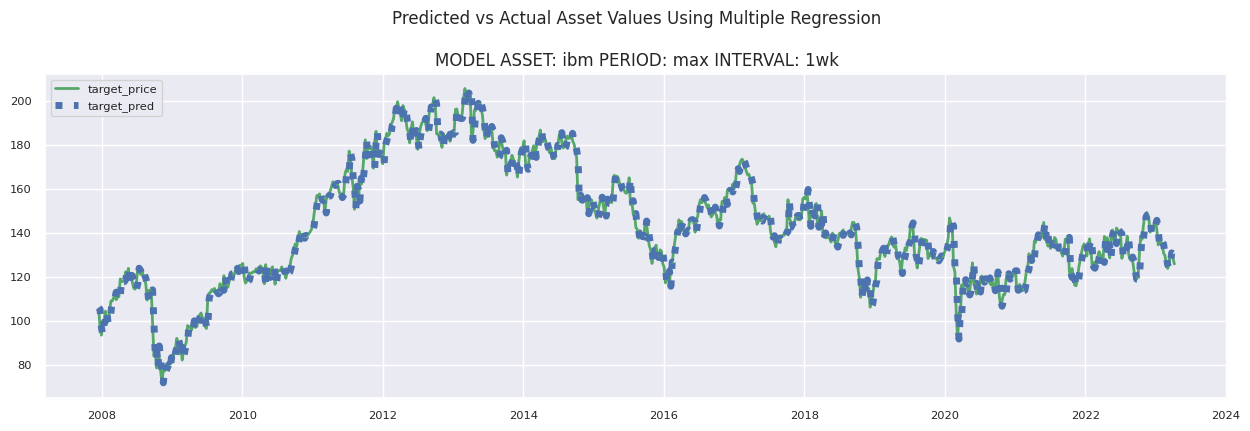


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_price  target_pred
date                                                                           
2023-02-06  135.83  136.74  133.34  135.60  22141000  135.02        135.377    
2023-02-13  136.00  137.39  133.89  135.02  16543600  130.57        134.861    
2023-02-20  134.00  134.39  128.86  130.57  14198800  129.64        130.383    
2023-02-27  131.42  131.87  127.71  129.64  17865500  125.45        129.436    
2023-03-06  129.64  130.86  125.13  125.45  20909600  123.69        125.434    
2023-03-13  125.15  128.19  121.71  123.69  66131400  125.29        123.850    
2023-03-20  124.31  127.22  122.60  125.29  20457800  131.09        125.086    
2023-03-27  126.47  131.48  126.47  131.09  20778500  130.50        130.759    
2023-04-03  130.97  132.61  130.32  130.50  13172200  128.14        130.385    
2023-04-10  129.83  131.10  126.00  128.14  19505900  125.73        12

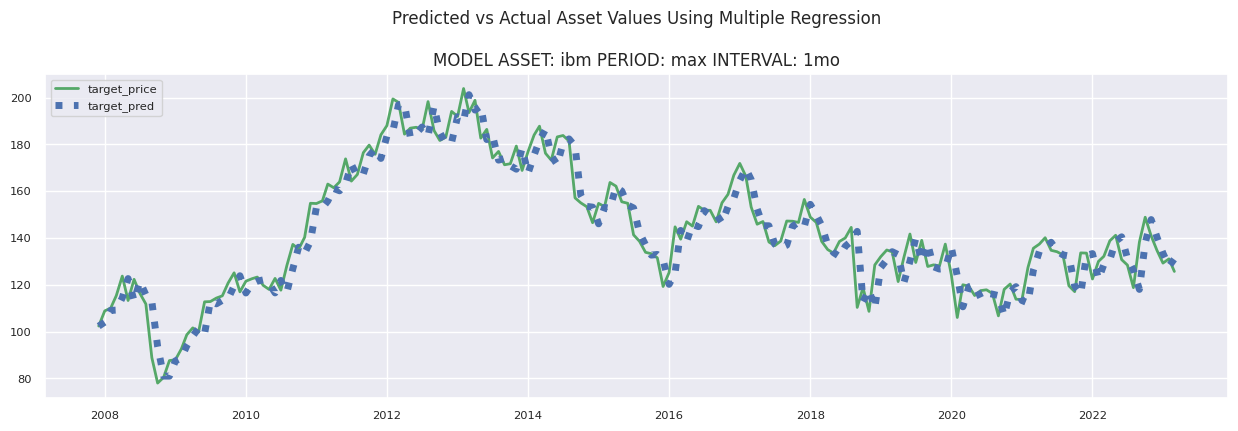


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_price  target_pred
date                                                                            
2022-06-01  139.67  144.73  132.85  141.19  105811300  130.79        140.532    
2022-07-01  141.00  141.87  125.13  130.79  129791800  128.45        131.353    
2022-08-01  130.75  139.34  128.40  128.45   77419800  118.81        126.238    
2022-09-01  128.40  130.99  118.61  118.81   87265100  138.29        118.055    
2022-10-01  120.16  138.86  115.55  138.29  113478200  148.90        137.870    
2022-11-01  138.25  150.46  133.97  148.90   93661300  140.89        147.909    
2022-12-01  149.98  153.21  137.20  140.89   86424100  134.73        140.382    
2023-01-01  141.10  147.18  132.98  134.73  105575000  129.30        133.497    
2023-02-01  134.49  137.39  128.86  129.30   76080200  131.09        127.924    
2023-03-01  128.90  131.48  121.71  131.09  138238400  125.

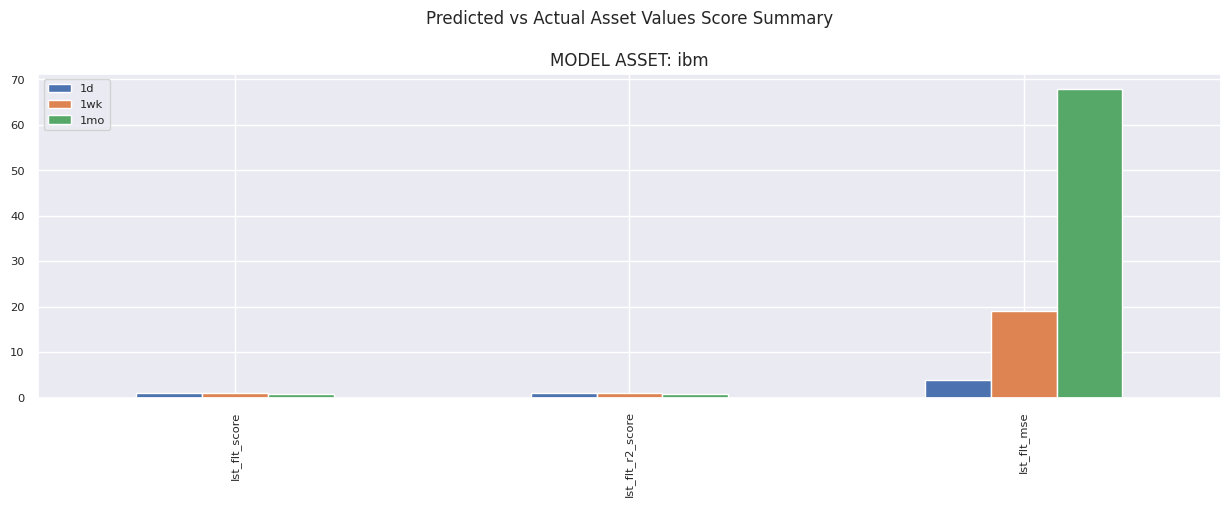

In [15]:
AssetData('ibm').run_mlr_model()

# Method run_mlr_model_list


 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.50325970e-01  2.80622183e-01  1.60257955e-01  7.07482479e-01
  2.76780571e-09]
 

Model Intercept: 
 
0.01643718516954351
 



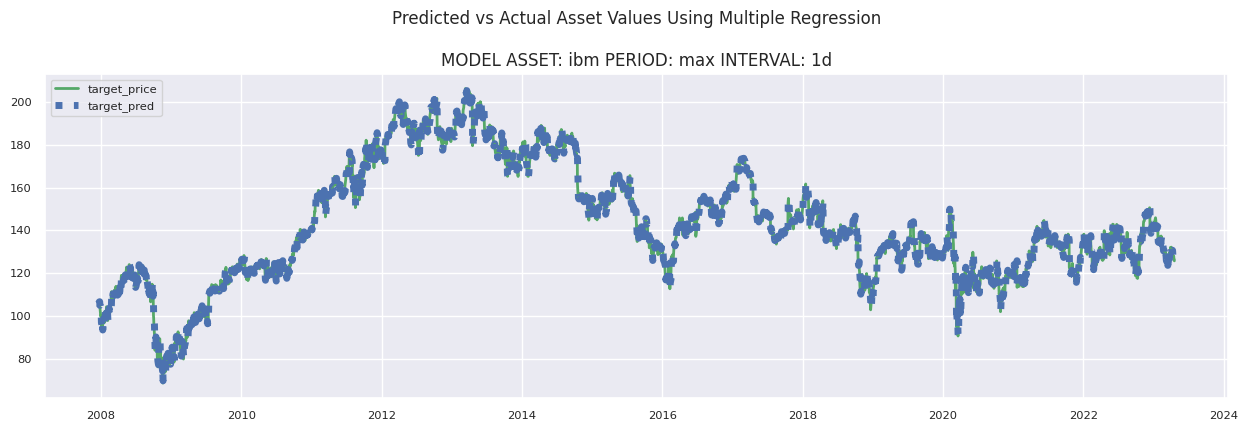


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_price  target_pred
date                                                                          
2023-04-06  132.16  132.60  130.32  130.50  3050600  131.03        130.580    
2023-04-10  129.83  131.08  129.24  131.03  2614400  130.42        130.704    
2023-04-11  130.58  131.10  130.18  130.42  3132400  128.54        130.317    
2023-04-12  130.40  130.89  128.17  128.54  3957500  127.90        128.636    
2023-04-13  128.01  128.39  126.00  127.90  5621500  128.14        127.497    
2023-04-14  128.46  129.84  127.31  128.14  4180100  127.82        128.212    
2023-04-17  128.30  128.72  126.80  127.82  3662700  127.78        127.613    
2023-04-18  128.14  128.68  127.35  127.78  3193800  126.32        127.684    
2023-04-19  126.50  126.98  125.30  126.32  7014400  126.36        126.103    
2023-04-20  130.15  130.98  125.84  126.36  9749600  125.73        126.799    
 


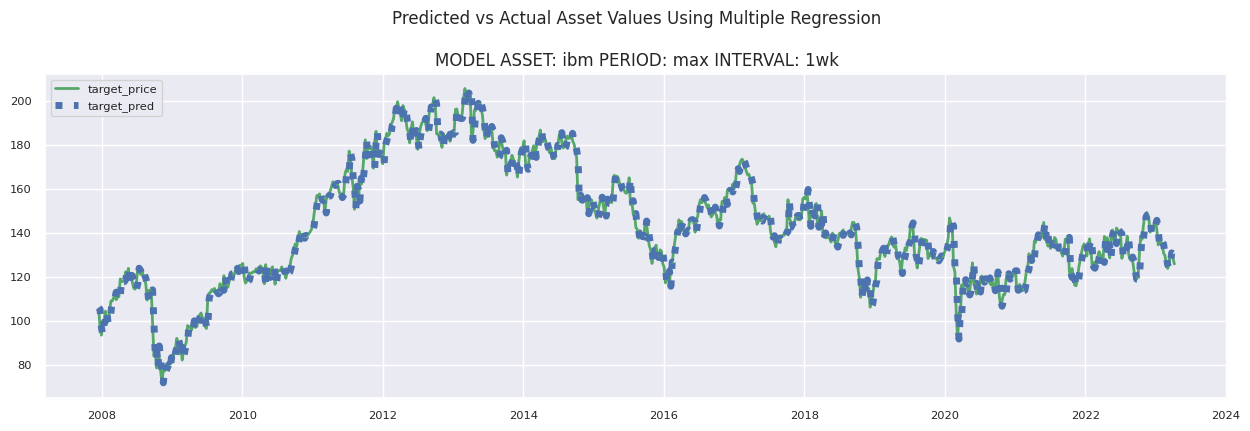


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_price  target_pred
date                                                                           
2023-02-06  135.83  136.74  133.34  135.60  22141000  135.02        135.377    
2023-02-13  136.00  137.39  133.89  135.02  16543600  130.57        134.861    
2023-02-20  134.00  134.39  128.86  130.57  14198800  129.64        130.383    
2023-02-27  131.42  131.87  127.71  129.64  17865500  125.45        129.436    
2023-03-06  129.64  130.86  125.13  125.45  20909600  123.69        125.434    
2023-03-13  125.15  128.19  121.71  123.69  66131400  125.29        123.850    
2023-03-20  124.31  127.22  122.60  125.29  20457800  131.09        125.086    
2023-03-27  126.47  131.48  126.47  131.09  20778500  130.50        130.759    
2023-04-03  130.97  132.61  130.32  130.50  13172200  128.14        130.385    
2023-04-10  129.83  131.10  126.00  128.14  19505900  125.73        12

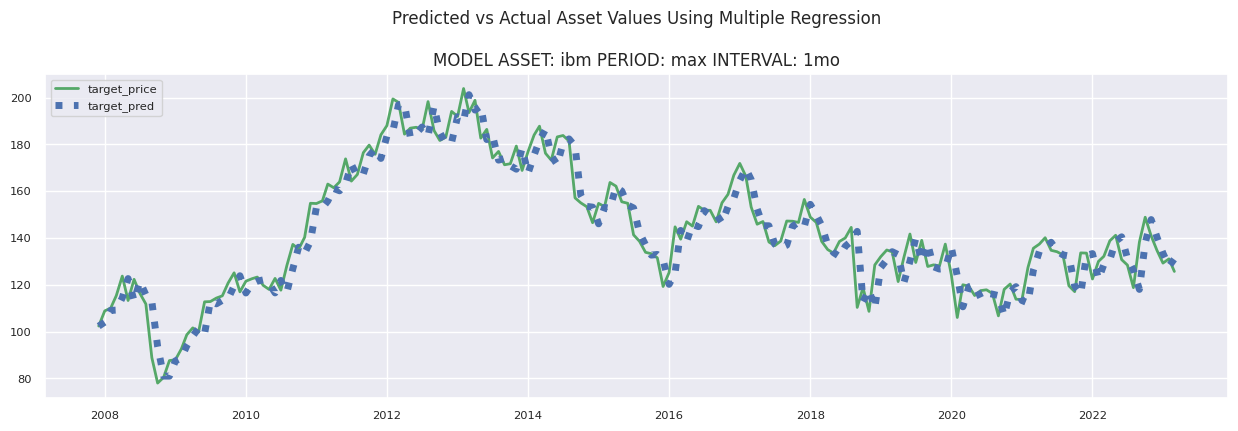


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_price  target_pred
date                                                                            
2022-06-01  139.67  144.73  132.85  141.19  105811300  130.79        140.532    
2022-07-01  141.00  141.87  125.13  130.79  129791800  128.45        131.353    
2022-08-01  130.75  139.34  128.40  128.45   77419800  118.81        126.238    
2022-09-01  128.40  130.99  118.61  118.81   87265100  138.29        118.055    
2022-10-01  120.16  138.86  115.55  138.29  113478200  148.90        137.870    
2022-11-01  138.25  150.46  133.97  148.90   93661300  140.89        147.909    
2022-12-01  149.98  153.21  137.20  140.89   86424100  134.73        140.382    
2023-01-01  141.10  147.18  132.98  134.73  105575000  129.30        133.497    
2023-02-01  134.49  137.39  128.86  129.30   76080200  131.09        127.924    
2023-03-01  128.90  131.48  121.71  131.09  138238400  125.

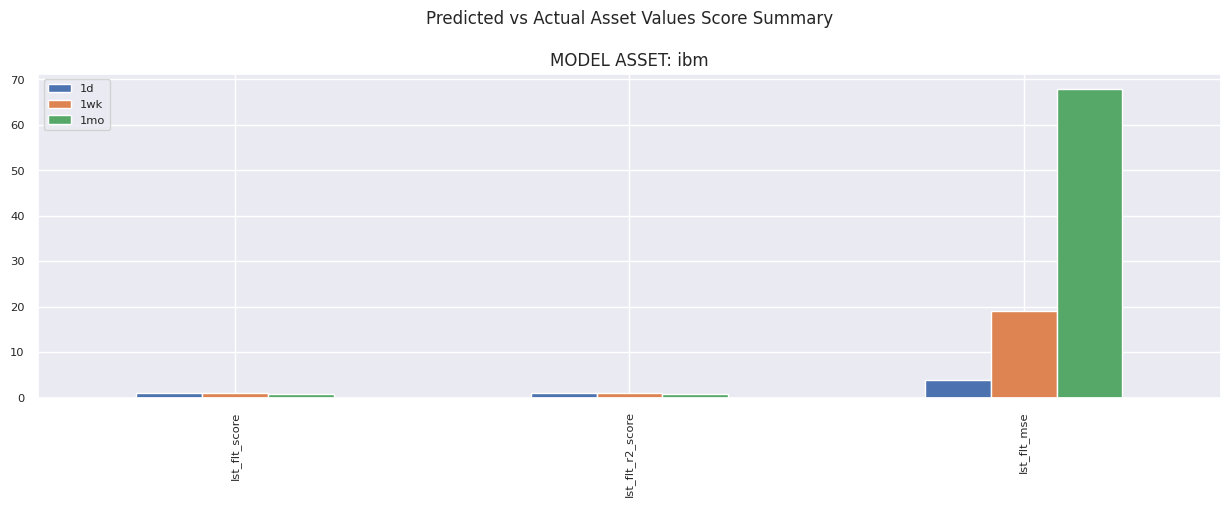


 

None

 
MODEL ASSET: ge PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ge-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-2.04705619e-01  3.01755927e-01  1.59944650e-01  7.40797881e-01
  4.94801305e-08]
 

Model Intercept: 
 
-0.03005952561858294
 



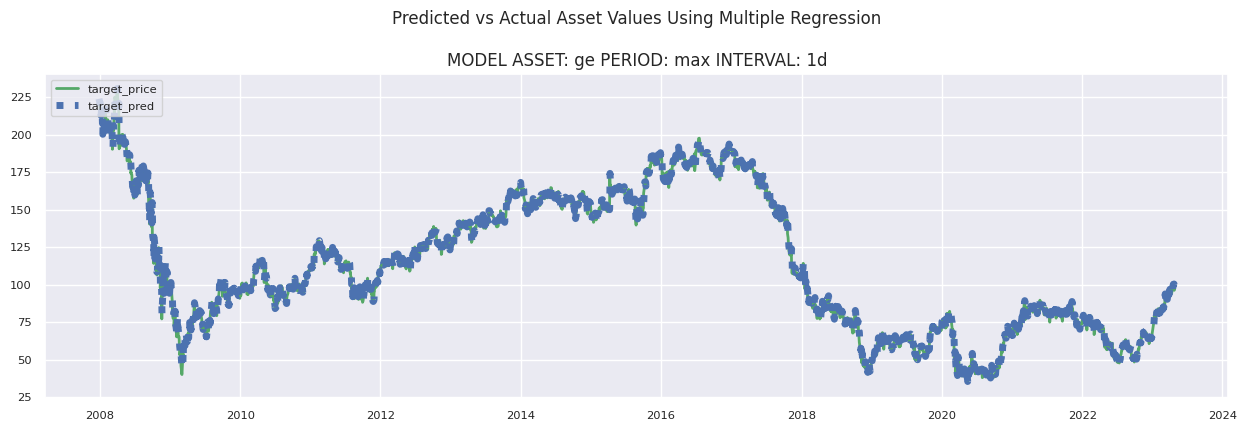


 

Feature, Target and Prediction Comparison: 
 
            open    high    low    close   volume   target_price  target_pred
date                                                                         
2023-04-14   93.86   95.64  93.81   95.44  5754600   96.770        95.607    
2023-04-17   95.62   96.85  95.48   96.77  6126100   98.470        96.883    
2023-04-18   97.00   98.52  96.86   98.47  7110800   99.030        98.633    
2023-04-19   98.58   99.31  98.42   99.03  5617000   99.760        99.138    
2023-04-20   99.30  100.47  99.06   99.76  6912400   99.510       100.048    
2023-04-21   99.98  100.08  99.13   99.51  4079400  100.150        99.477    
2023-04-24   99.58  100.77  99.58  100.15  6251800   98.440       100.421    
2023-04-25  101.95  102.01  97.55   98.44  9297500   96.210        98.869    
2023-04-26   98.23   98.45  96.09   96.21  6410500   98.060        96.528    
2023-04-27   97.02   98.19  96.60   98.06  7458800   99.105        98.201    
 


 
MODEL AS

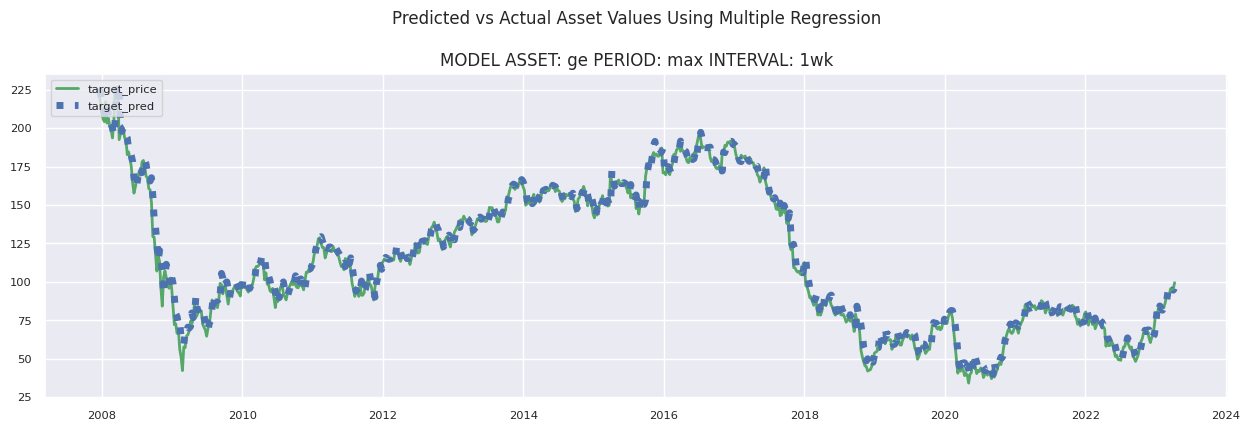


 

Feature, Target and Prediction Comparison: 
 
            open   high   low    close  volume    target_price  target_pred
date                                                                       
2023-02-06  81.47  82.63  80.40  81.29  19790900  83.04         81.664     
2023-02-13  81.20  84.79  81.08  83.04  24210700  83.55         83.506     
2023-02-20  82.14  84.41  81.65  83.55  27738300  86.38         84.096     
2023-02-27  84.00  87.04  83.38  86.38  36014800  91.00         87.197     
2023-03-06  86.64  94.94  86.07  91.00  66484000  90.29         93.366     
2023-03-13  89.70  93.08  86.45  90.29  53054500  91.37         92.240     
2023-03-20  90.63  93.04  89.41  91.37  36090800  95.60         92.371     
2023-03-27  92.28  95.67  92.11  95.60  27594000  93.60         95.869     
2023-04-03  95.75  97.87  93.54  93.60  26673600  95.44         94.655     
2023-04-10  93.83  95.64  93.47  95.44  32870100  99.51         96.034     
 


 
MODEL ASSET: ge PERIOD: max INTE

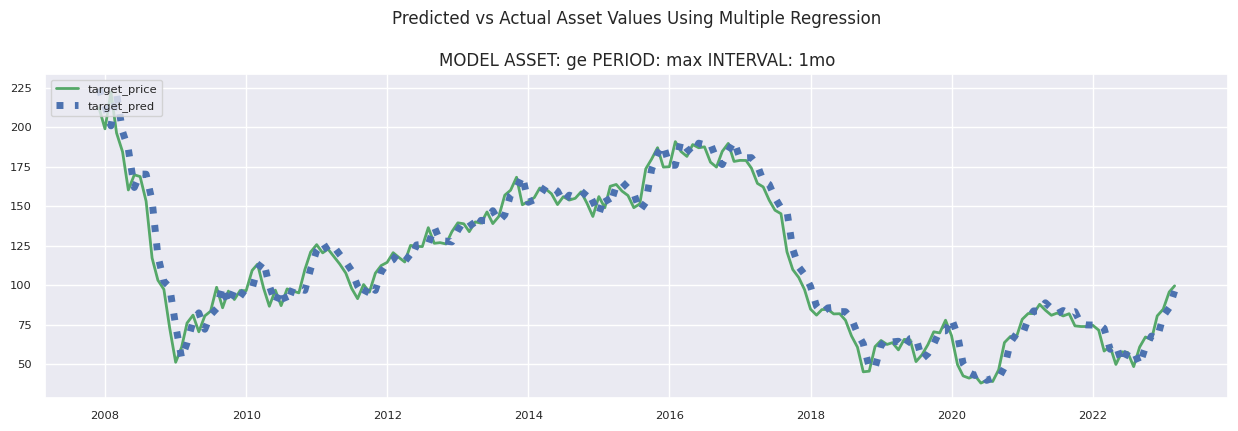


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_price  target_pred
date                                                                            
2022-06-01  61.733  62.014  48.212  49.703  190537220  57.697        50.769     
2022-07-01  49.563  58.470  46.784  57.697  180923701  57.330        57.970     
2022-08-01  57.221  63.466  56.745  57.330  162417348  48.329        58.536     
2022-09-01  57.182  59.711  48.306  48.329  179641805  60.742        49.490     
2022-10-01  48.993  61.561  48.517  60.742  163760479  67.112        60.738     
2022-11-01  61.327  68.993  59.774  67.112  148623415  65.410        67.682     
2022-12-01  67.299  67.994  59.867  65.410  154746594  80.480        66.292     
2023-01-01  65.613  83.990  65.215  80.480  192435233  84.710        80.257     
2023-02-01  80.270  85.650  80.010  84.710  108604900  95.600        85.587     
2023-03-01  84.660  95.670  83.380  95.600  203716600  99.5

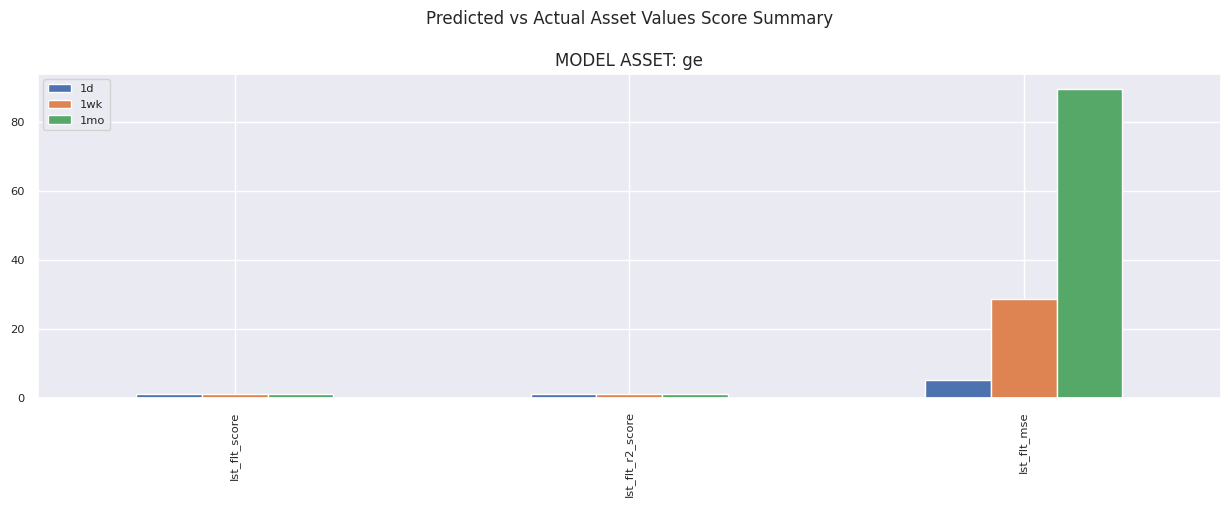


 

None

 
MODEL ASSET: ibm PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/ibm-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-1.50325970e-01  2.80622183e-01  1.60257955e-01  7.07482479e-01
  2.76780571e-09]
 

Model Intercept: 
 
0.01643718516954351
 



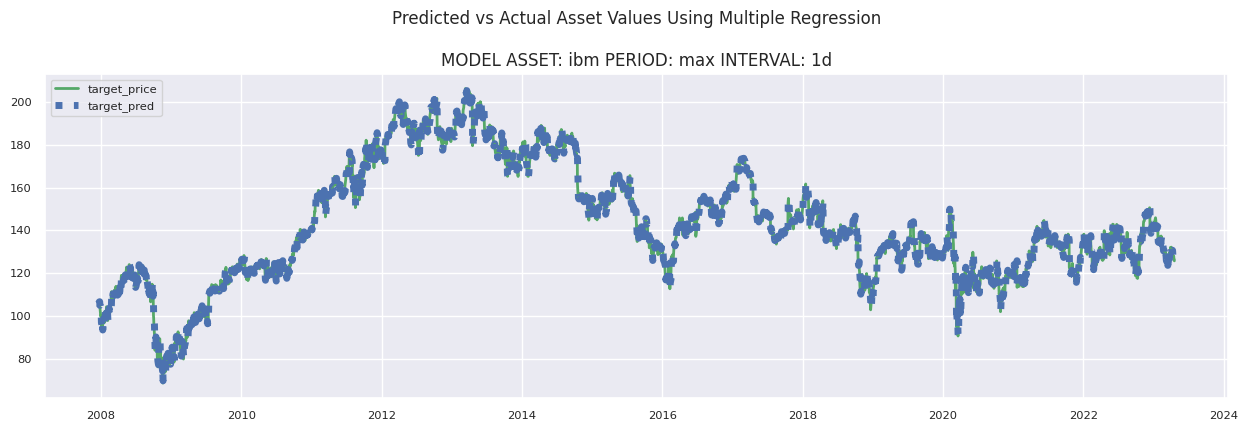


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume   target_price  target_pred
date                                                                          
2023-04-06  132.16  132.60  130.32  130.50  3050600  131.03        130.580    
2023-04-10  129.83  131.08  129.24  131.03  2614400  130.42        130.704    
2023-04-11  130.58  131.10  130.18  130.42  3132400  128.54        130.317    
2023-04-12  130.40  130.89  128.17  128.54  3957500  127.90        128.636    
2023-04-13  128.01  128.39  126.00  127.90  5621500  128.14        127.497    
2023-04-14  128.46  129.84  127.31  128.14  4180100  127.82        128.212    
2023-04-17  128.30  128.72  126.80  127.82  3662700  127.78        127.613    
2023-04-18  128.14  128.68  127.35  127.78  3193800  126.32        127.684    
2023-04-19  126.50  126.98  125.30  126.32  7014400  126.36        126.103    
2023-04-20  130.15  130.98  125.84  126.36  9749600  125.73        126.799    
 


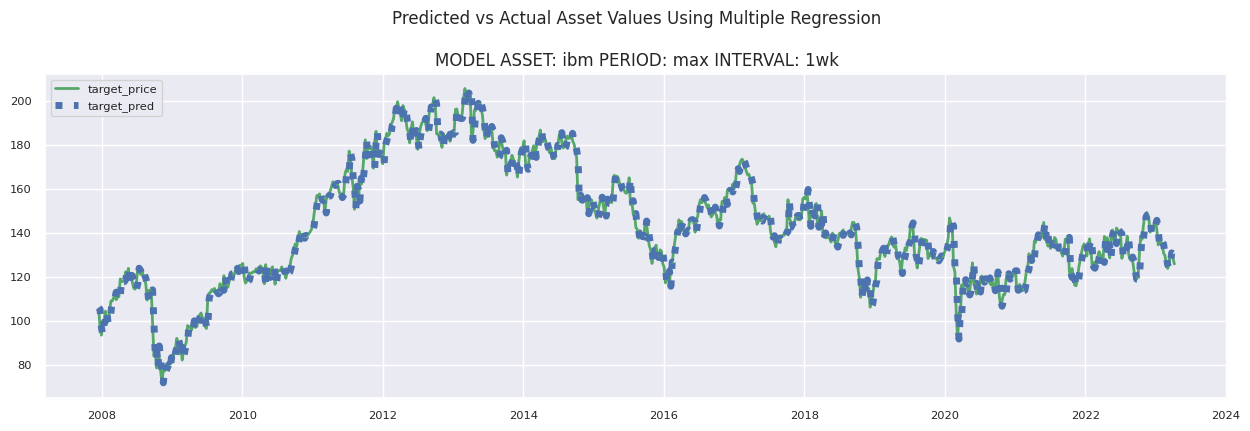


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume    target_price  target_pred
date                                                                           
2023-02-06  135.83  136.74  133.34  135.60  22141000  135.02        135.377    
2023-02-13  136.00  137.39  133.89  135.02  16543600  130.57        134.861    
2023-02-20  134.00  134.39  128.86  130.57  14198800  129.64        130.383    
2023-02-27  131.42  131.87  127.71  129.64  17865500  125.45        129.436    
2023-03-06  129.64  130.86  125.13  125.45  20909600  123.69        125.434    
2023-03-13  125.15  128.19  121.71  123.69  66131400  125.29        123.850    
2023-03-20  124.31  127.22  122.60  125.29  20457800  131.09        125.086    
2023-03-27  126.47  131.48  126.47  131.09  20778500  130.50        130.759    
2023-04-03  130.97  132.61  130.32  130.50  13172200  128.14        130.385    
2023-04-10  129.83  131.10  126.00  128.14  19505900  125.73        12

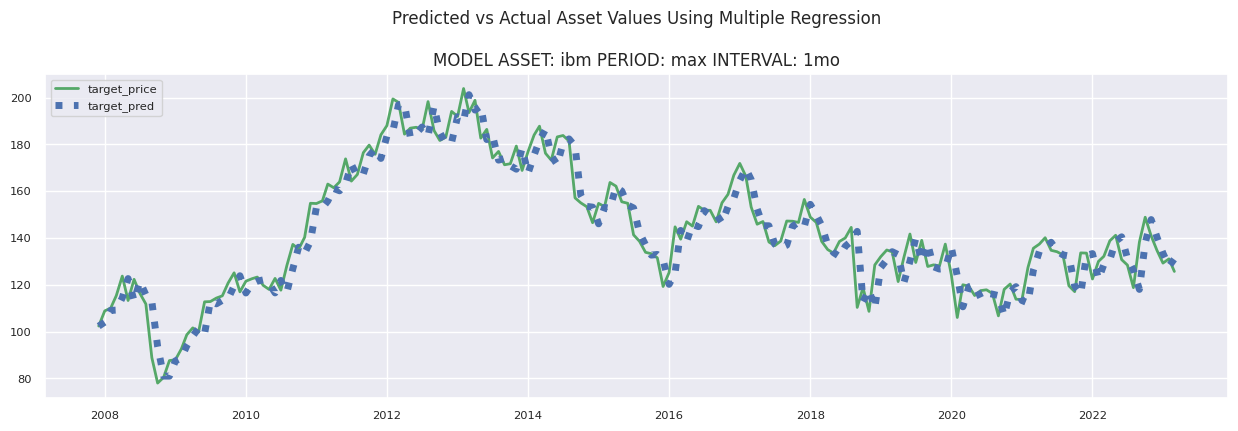


 

Feature, Target and Prediction Comparison: 
 
            open    high    low     close   volume     target_price  target_pred
date                                                                            
2022-06-01  139.67  144.73  132.85  141.19  105811300  130.79        140.532    
2022-07-01  141.00  141.87  125.13  130.79  129791800  128.45        131.353    
2022-08-01  130.75  139.34  128.40  128.45   77419800  118.81        126.238    
2022-09-01  128.40  130.99  118.61  118.81   87265100  138.29        118.055    
2022-10-01  120.16  138.86  115.55  138.29  113478200  148.90        137.870    
2022-11-01  138.25  150.46  133.97  148.90   93661300  140.89        147.909    
2022-12-01  149.98  153.21  137.20  140.89   86424100  134.73        140.382    
2023-01-01  141.10  147.18  132.98  134.73  105575000  129.30        133.497    
2023-02-01  134.49  137.39  128.86  129.30   76080200  131.09        127.924    
2023-03-01  128.90  131.48  121.71  131.09  138238400  125.

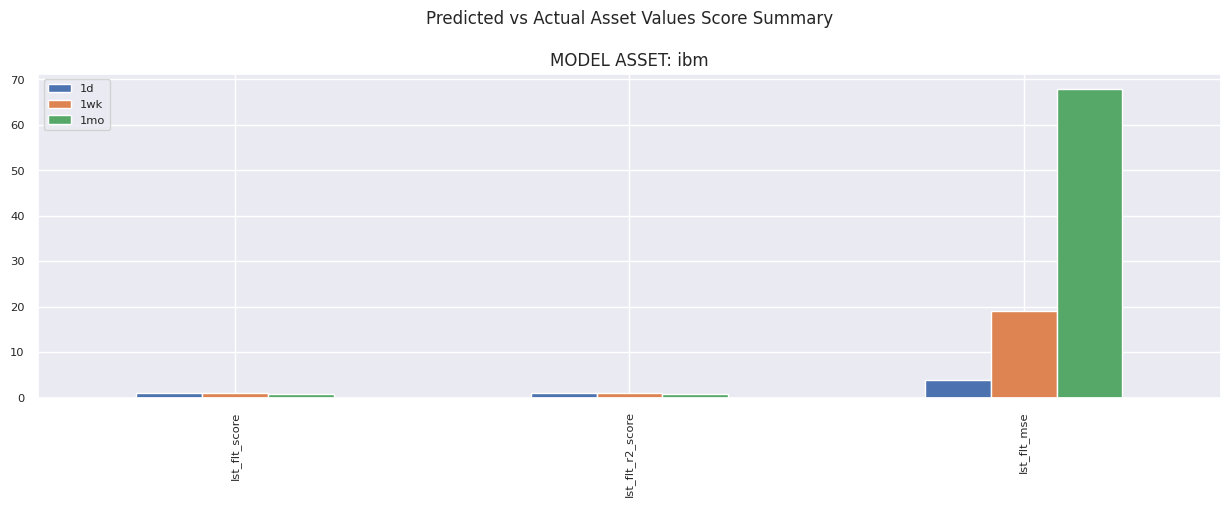


 

None


In [16]:
AssetData('ibm').run_mlr_model_list(['ibm', 'ge'])